In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [7]:
import os
import shutil

def clean_kaggle_output_directory(output_dir):
    """
    Removes all files and subdirectories in the specified output directory.
    If the directory does not exist, it is created.
    """
    if os.path.exists(output_dir):
        # Remove everything in the output directory
        for filename in os.listdir(output_dir):
            file_path = os.path.join(output_dir, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)  # remove file or link
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)  # remove directory
            except Exception as e:
                print(f"Failed to delete {file_path}. Reason: {e}")
    else:
        os.makedirs(output_dir)
    print(f"Output directory '{output_dir}' is now clean and ready.")

# Example usage:
kaggle_output_dir = "/kaggle/working/"  # adjust this path as needed
clean_kaggle_output_directory(kaggle_output_dir)


Output directory '/kaggle/working/' is now clean and ready.


In [2]:
import os

def count_images_in_dir(directory):
    """Count the number of image files in each subfolder of the given directory."""
    counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            # Count files that are images (assumes image files have common extensions)
            image_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')
            num_images = sum(1 for fname in os.listdir(class_path)
                             if fname.lower().endswith(image_extensions))
            counts[class_name] = num_images
    return counts

# Define the base dataset directory.
data_dir = '/kaggle/input/unet-segmented'

# Count images for train and test sets.
for subset in ['train', 'test']:
    subset_dir = os.path.join(data_dir, subset)
    counts = count_images_in_dir(subset_dir)
    print(f"{subset.capitalize()} set:")
    for class_name, count in counts.items():
        print(f"  {class_name}: {count} images")


Train set:
  benign: 1440 images
  malignant: 1197 images
Test set:
  benign: 360 images
  malignant: 300 images


# cycleGAN

**train/malignant**

In [3]:
import os
import glob
import time
import random
import zipfile
import itertools
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt

# ---------------------------
# 1. Setup & Reproducibility
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if device.type == 'cuda':
    torch.cuda.manual_seed(seed)

# ---------------------------
# 2. Dataset Preparation
# ---------------------------
# Custom dataset for a single folder (assumes folder contains only images)
class SingleFolderDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.folder = folder
        self.image_paths = glob.glob(os.path.join(folder, "*"))
        self.transform = transform
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img

# Define two transforms: Domain A is the original image; Domain B uses heavy augmentations.
transform_A = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
transform_B = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ColorJitter(brightness=0.8, contrast=0.8, saturation=0.8, hue=0.2),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Set your dataset base path (adjust this path to point to your dataset)
dataset_base = "/kaggle/input/unet-segmented"  # e.g., "/kaggle/input/skin-cancer-dataset"

# Then set the specific folder for malignant images:
malignant_folder = os.path.join(dataset_base, "train", "malignant")


# Create datasets for two domains using the same images
dataset_A = SingleFolderDataset(malignant_folder, transform=transform_A)
dataset_B = SingleFolderDataset(malignant_folder, transform=transform_B)

# DataLoaders (CycleGAN commonly uses batch_size=1)
batch_size = 1
loader_A = DataLoader(dataset_A, batch_size=batch_size, shuffle=True, num_workers=4)
loader_B = DataLoader(dataset_B, batch_size=batch_size, shuffle=True, num_workers=4)

# Create an iterator that zips the two dataloaders (unpaired training is assumed)
def dataloader_zip(loader_A, loader_B):
    return zip(loader_A, loader_B)
data_loader = dataloader_zip(loader_A, loader_B)

# ---------------------------
# 3. Define CycleGAN Networks
# ---------------------------
# Residual block used in the generator
class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3),
            nn.InstanceNorm2d(dim),
            nn.ReLU(True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3),
            nn.InstanceNorm2d(dim)
        )
    def forward(self, x):
        return x + self.block(x)

# Generator network (ResNet-based)
class ResnetGenerator(nn.Module):
    def __init__(self, input_nc, output_nc, ngf=64, n_blocks=9):
        assert(n_blocks >= 0)
        super(ResnetGenerator, self).__init__()
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_nc, ngf, kernel_size=7),
            nn.InstanceNorm2d(ngf),
            nn.ReLU(True)
        ]
        # Downsampling
        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2 ** i
            model += [
                nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1),
                nn.InstanceNorm2d(ngf * mult * 2),
                nn.ReLU(True)
            ]
        # Residual blocks
        mult = 2 ** n_downsampling
        for i in range(n_blocks):
            model += [ResidualBlock(ngf * mult)]
        # Upsampling
        for i in range(n_downsampling):
            mult = 2 ** (n_downsampling - i)
            model += [
                nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2), kernel_size=3, stride=2,
                                   padding=1, output_padding=1),
                nn.InstanceNorm2d(int(ngf * mult / 2)),
                nn.ReLU(True)
            ]
        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(ngf, output_nc, kernel_size=7),
            nn.Tanh()
        ]
        self.model = nn.Sequential(*model)
    def forward(self, input):
        return self.model(input)

# PatchGAN Discriminator
class NLayerDiscriminator(nn.Module):
    def __init__(self, input_nc, ndf=64, n_layers=3):
        super(NLayerDiscriminator, self).__init__()
        kw = 4
        padw = 1
        sequence = [
            nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw),
            nn.LeakyReLU(0.2, True)
        ]
        nf_mult = 1
        for n in range(1, n_layers):
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw),
                nn.InstanceNorm2d(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]
        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw),
            nn.InstanceNorm2d(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]
        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]
        self.model = nn.Sequential(*sequence)
    def forward(self, input):
        return self.model(input)

# Instantiate networks and move to device
G_A2B = ResnetGenerator(3, 3, n_blocks=9).to(device)  # maps domain A -> domain B
G_B2A = ResnetGenerator(3, 3, n_blocks=9).to(device)  # maps domain B -> domain A
D_A = NLayerDiscriminator(3).to(device)  # discriminates domain A
D_B = NLayerDiscriminator(3).to(device)  # discriminates domain B

# ---------------------------
# 4. Losses & Optimizers
# ---------------------------
criterion_GAN = nn.MSELoss().to(device)
criterion_cycle = nn.L1Loss().to(device)
criterion_identity = nn.L1Loss().to(device)

lr = 0.0002
beta1 = 0.5
optimizer_G = optim.Adam(itertools.chain(G_A2B.parameters(), G_B2A.parameters()), lr=lr, betas=(beta1, 0.999))
optimizer_D_A = optim.Adam(D_A.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D_B = optim.Adam(D_B.parameters(), lr=lr, betas=(beta1, 0.999))

# ---------------------------
# 5. Training Loop for CycleGAN
# ---------------------------
num_epochs = 50
# Folder to save generated images per epoch
epoch_save_dir = "/kaggle/working/epoch_images"
os.makedirs(epoch_save_dir, exist_ok=True)

# Prepare fixed images for monitoring progress (one sample from each loader)
fixed_A = next(iter(loader_A)).to(device)
fixed_B = next(iter(loader_B)).to(device)

# CycleGAN uses PatchGAN so we create a “valid” map of labels.
def create_target_tensor(input_tensor, value):
    # Assuming the discriminator output is 30x30 (depends on image size and architecture)
    return torch.full((input_tensor.size(0), 1, 30, 30), value, device=device)

for epoch in range(1, num_epochs + 1):
    start_time = time.time()
    for i, (real_A, real_B) in enumerate(data_loader):
        real_A = real_A.to(device)
        real_B = real_B.to(device)
        valid = create_target_tensor(real_A, 1.0)
        fake = create_target_tensor(real_A, 0.0)

        # -------------------
        # Train Generators
        # -------------------
        optimizer_G.zero_grad()

        # Identity loss: G_B2A(real_A) should equal real_A and G_A2B(real_B) should equal real_B
        loss_id_A = criterion_identity(G_B2A(real_A), real_A)
        loss_id_B = criterion_identity(G_A2B(real_B), real_B)
        loss_identity = (loss_id_A + loss_id_B) * 0.5

        # GAN loss
        fake_B = G_A2B(real_A)
        loss_GAN_A2B = criterion_GAN(D_B(fake_B), valid)
        fake_A = G_B2A(real_B)
        loss_GAN_B2A = criterion_GAN(D_A(fake_A), valid)
        loss_GAN = (loss_GAN_A2B + loss_GAN_B2A) * 0.5

        # Cycle consistency loss: G_B2A(G_A2B(real_A)) should equal real_A, and vice versa.
        rec_A = G_B2A(fake_B)
        loss_cycle_A = criterion_cycle(rec_A, real_A)
        rec_B = G_A2B(fake_A)
        loss_cycle_B = criterion_cycle(rec_B, real_B)
        loss_cycle = (loss_cycle_A + loss_cycle_B) * 10.0

        # Total generator loss
        loss_G = loss_identity + loss_GAN + loss_cycle
        loss_G.backward()
        optimizer_G.step()

        # -------------------
        # Train Discriminator A
        # -------------------
        optimizer_D_A.zero_grad()
        loss_D_A_real = criterion_GAN(D_A(real_A), valid)
        loss_D_A_fake = criterion_GAN(D_A(fake_A.detach()), fake)
        loss_D_A = (loss_D_A_real + loss_D_A_fake) * 0.5
        loss_D_A.backward()
        optimizer_D_A.step()

        # -------------------
        # Train Discriminator B
        # -------------------
        optimizer_D_B.zero_grad()
        loss_D_B_real = criterion_GAN(D_B(real_B), valid)
        loss_D_B_fake = criterion_GAN(D_B(fake_B.detach()), fake)
        loss_D_B = (loss_D_B_real + loss_D_B_fake) * 0.5
        loss_D_B.backward()
        optimizer_D_B.step()

    elapsed = time.time() - start_time
    print(f"Epoch [{epoch}/{num_epochs}] - Loss_G: {loss_G.item():.4f}, Loss_D_A: {loss_D_A.item():.4f}, Loss_D_B: {loss_D_B.item():.4f}, Time: {elapsed:.2f}s")

    # Save generated images on fixed sample from domain A at the end of each epoch
    with torch.no_grad():
        fake_B_fixed = G_A2B(fixed_A)
    epoch_image_path = os.path.join(epoch_save_dir, f"epoch_{epoch}.png")
    vutils.save_image(fake_B_fixed, epoch_image_path, normalize=True)

# ---------------------------
# 6. Generate 243 New Images & Zip Output
# ---------------------------
# Folder to store final generated images
final_output_dir = "/kaggle/working/final_output"
os.makedirs(final_output_dir, exist_ok=True)

# Randomly sample 243 indices from dataset_A (from malignant images)
num_new_images = 243
indices = random.sample(range(len(dataset_A)), num_new_images)

for idx in indices:
    # Get image from domain A and generate new image via G_A2B
    img = dataset_A[idx]
    img_tensor = img.unsqueeze(0).to(device)  # add batch dimension
    with torch.no_grad():
        generated_img = G_A2B(img_tensor)
    save_filename = os.path.join(final_output_dir, f"generated_{idx}.png")
    vutils.save_image(generated_img, save_filename, normalize=True)

# Create a zip file of the final generated images (for Kaggle output)
zip_filename = "/kaggle/working/generated_images_u-net++.zip"
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for root, _, files in os.walk(final_output_dir):
        for file in files:
            zipf.write(os.path.join(root, file), arcname=file)
print(f"Zip file saved as: {zip_filename}")


Using device: cuda
Epoch [1/50] - Loss_G: 3.7959, Loss_D_A: 0.1367, Loss_D_B: 0.1673, Time: 398.88s
Epoch [2/50] - Loss_G: 3.7959, Loss_D_A: 0.1367, Loss_D_B: 0.1673, Time: 0.00s
Epoch [3/50] - Loss_G: 3.7959, Loss_D_A: 0.1367, Loss_D_B: 0.1673, Time: 0.00s
Epoch [4/50] - Loss_G: 3.7959, Loss_D_A: 0.1367, Loss_D_B: 0.1673, Time: 0.00s
Epoch [5/50] - Loss_G: 3.7959, Loss_D_A: 0.1367, Loss_D_B: 0.1673, Time: 0.00s
Epoch [6/50] - Loss_G: 3.7959, Loss_D_A: 0.1367, Loss_D_B: 0.1673, Time: 0.00s
Epoch [7/50] - Loss_G: 3.7959, Loss_D_A: 0.1367, Loss_D_B: 0.1673, Time: 0.00s
Epoch [8/50] - Loss_G: 3.7959, Loss_D_A: 0.1367, Loss_D_B: 0.1673, Time: 0.00s
Epoch [9/50] - Loss_G: 3.7959, Loss_D_A: 0.1367, Loss_D_B: 0.1673, Time: 0.00s
Epoch [10/50] - Loss_G: 3.7959, Loss_D_A: 0.1367, Loss_D_B: 0.1673, Time: 0.00s
Epoch [11/50] - Loss_G: 3.7959, Loss_D_A: 0.1367, Loss_D_B: 0.1673, Time: 0.00s
Epoch [12/50] - Loss_G: 3.7959, Loss_D_A: 0.1367, Loss_D_B: 0.1673, Time: 0.00s
Epoch [13/50] - Loss_G: 3.79

**test/malignant**

In [6]:
import os
import glob
import time
import random
import zipfile
import itertools
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt

# ======================================================
# 1. Setup & Reproducibility
# ======================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if device.type == 'cuda':
    torch.cuda.manual_seed(seed)

# ======================================================
# 2. Dataset Path & Cleaning Kaggle Output Directory
# ======================================================
# Set your dataset base path (adjust this path to point to your dataset)
dataset_base = "/kaggle/input/unet-segmented"  # Change to your dataset directory

# Use test/malignant folder for CycleGAN training
malignant_folder = os.path.join(dataset_base, "test", "malignant")
print("Malignant folder:", malignant_folder)

# Kaggle output directory for final results
kaggle_output_dir = "/kaggle/working/final-results"
os.makedirs(kaggle_output_dir, exist_ok=True)

def clean_directory(directory):
    if os.path.exists(directory):
        for filename in os.listdir(directory):
            file_path = os.path.join(directory, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    import shutil
                    shutil.rmtree(file_path)
            except Exception as e:
                print(f"Failed to delete {file_path}. Reason: {e}")
    else:
        os.makedirs(directory)
    print(f"Directory '{directory}' is now clean.")
    
# Clean the output directory before saving new results.
clean_directory(kaggle_output_dir)

# ======================================================
# 3. Dataset Preparation & Transforms
# ======================================================
# Custom dataset for a single folder
class SingleFolderDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.folder = folder
        self.image_paths = glob.glob(os.path.join(folder, "*"))
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img

# Domain A: Original images; Domain B: Strong augmentations
transform_A = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    # Normalize to [-1, 1] for Tanh activation at output of generator
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
transform_B = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ColorJitter(brightness=0.8, contrast=0.8, saturation=0.8, hue=0.2),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create datasets using the same malignant folder for both domains
dataset_A = SingleFolderDataset(malignant_folder, transform=transform_A)
dataset_B = SingleFolderDataset(malignant_folder, transform=transform_B)

# DataLoaders (batch_size=1 is standard for CycleGAN)
batch_size = 1
loader_A = DataLoader(dataset_A, batch_size=batch_size, shuffle=True, num_workers=4)
loader_B = DataLoader(dataset_B, batch_size=batch_size, shuffle=True, num_workers=4)

# Create an iterator that zips the two loaders (unpaired training)
def dataloader_zip(loader_A, loader_B):
    return zip(loader_A, loader_B)
data_loader = dataloader_zip(loader_A, loader_B)

# ======================================================
# 4. Define CycleGAN Networks
# ======================================================
# Residual Block used in the generators
class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3),
            nn.InstanceNorm2d(dim),
            nn.ReLU(True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3),
            nn.InstanceNorm2d(dim)
        )
    def forward(self, x):
        return x + self.block(x)

# Generator (ResNet-based)
class ResnetGenerator(nn.Module):
    def __init__(self, input_nc, output_nc, ngf=64, n_blocks=9):
        assert(n_blocks >= 0)
        super(ResnetGenerator, self).__init__()
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_nc, ngf, kernel_size=7),
            nn.InstanceNorm2d(ngf),
            nn.ReLU(True)
        ]
        # Downsampling
        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2 ** i
            model += [
                nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1),
                nn.InstanceNorm2d(ngf * mult * 2),
                nn.ReLU(True)
            ]
        # Residual blocks
        mult = 2 ** n_downsampling
        for i in range(n_blocks):
            model += [ResidualBlock(ngf * mult)]
        # Upsampling
        for i in range(n_downsampling):
            mult = 2 ** (n_downsampling - i)
            model += [
                nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2), kernel_size=3, stride=2,
                                   padding=1, output_padding=1),
                nn.InstanceNorm2d(int(ngf * mult / 2)),
                nn.ReLU(True)
            ]
        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(ngf, output_nc, kernel_size=7),
            nn.Tanh()
        ]
        self.model = nn.Sequential(*model)
    def forward(self, input):
        return self.model(input)

# PatchGAN Discriminator
class NLayerDiscriminator(nn.Module):
    def __init__(self, input_nc, ndf=64, n_layers=3):
        super(NLayerDiscriminator, self).__init__()
        kw = 4
        padw = 1
        sequence = [
            nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw),
            nn.LeakyReLU(0.2, True)
        ]
        nf_mult = 1
        for n in range(1, n_layers):
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw),
                nn.InstanceNorm2d(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]
        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw),
            nn.InstanceNorm2d(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]
        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]
        self.model = nn.Sequential(*sequence)
    def forward(self, input):
        return self.model(input)

# Instantiate generators and discriminators
G_A2B = ResnetGenerator(3, 3, n_blocks=9).to(device)  # Maps original -> augmented
G_B2A = ResnetGenerator(3, 3, n_blocks=9).to(device)  # Maps augmented -> original
D_A = NLayerDiscriminator(3).to(device)  # Discriminates domain A
D_B = NLayerDiscriminator(3).to(device)  # Discriminates domain B

# ======================================================
# 5. Define Loss Functions & Optimizers
# ======================================================
criterion_GAN = nn.MSELoss().to(device)
criterion_cycle = nn.L1Loss().to(device)
criterion_identity = nn.L1Loss().to(device)

lr = 0.0002
beta1 = 0.5
optimizer_G = optim.Adam(itertools.chain(G_A2B.parameters(), G_B2A.parameters()), lr=lr, betas=(beta1, 0.999))
optimizer_D_A = optim.Adam(D_A.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D_B = optim.Adam(D_B.parameters(), lr=lr, betas=(beta1, 0.999))

# ======================================================
# 6. Training Loop for CycleGAN
# ======================================================
num_epochs = 50

# Folder to save per-epoch generated images (for monitoring progress)
epoch_save_dir = "/kaggle/working/epoch_images"
os.makedirs(epoch_save_dir, exist_ok=True)

# Use a fixed sample from domain A for visualization
fixed_A = next(iter(loader_A)).to(device)

# Helper function to create target tensors for PatchGAN
def create_target_tensor(input_tensor, value):
    # Adjust size as needed (e.g., 30x30 for a 256x256 input image using PatchGAN)
    return torch.full((input_tensor.size(0), 1, 30, 30), value, device=device)

print("Starting CycleGAN training...")
for epoch in range(1, num_epochs + 1):
    start_time = time.time()
    for i, (real_A, real_B) in enumerate(data_loader):
        real_A = real_A.to(device)
        real_B = real_B.to(device)
        valid = create_target_tensor(real_A, 1.0)
        fake = create_target_tensor(real_A, 0.0)

        # -------------------------
        # Train Generators
        # -------------------------
        optimizer_G.zero_grad()

        # Identity loss: generators should preserve color composition
        loss_id_A = criterion_identity(G_B2A(real_A), real_A)
        loss_id_B = criterion_identity(G_A2B(real_B), real_B)
        loss_identity = (loss_id_A + loss_id_B) * 0.5

        # GAN loss
        fake_B = G_A2B(real_A)
        loss_GAN_A2B = criterion_GAN(D_B(fake_B), valid)
        fake_A = G_B2A(real_B)
        loss_GAN_B2A = criterion_GAN(D_A(fake_A), valid)
        loss_GAN = (loss_GAN_A2B + loss_GAN_B2A) * 0.5

        # Cycle consistency loss: image should come back to original domain
        rec_A = G_B2A(fake_B)
        loss_cycle_A = criterion_cycle(rec_A, real_A)
        rec_B = G_A2B(fake_A)
        loss_cycle_B = criterion_cycle(rec_B, real_B)
        loss_cycle = (loss_cycle_A + loss_cycle_B) * 10.0

        # Total generator loss
        loss_G = loss_identity + loss_GAN + loss_cycle
        loss_G.backward()
        optimizer_G.step()

        # -------------------------
        # Train Discriminator A
        # -------------------------
        optimizer_D_A.zero_grad()
        loss_D_A_real = criterion_GAN(D_A(real_A), valid)
        loss_D_A_fake = criterion_GAN(D_A(fake_A.detach()), fake)
        loss_D_A = (loss_D_A_real + loss_D_A_fake) * 0.5
        loss_D_A.backward()
        optimizer_D_A.step()

        # -------------------------
        # Train Discriminator B
        # -------------------------
        optimizer_D_B.zero_grad()
        loss_D_B_real = criterion_GAN(D_B(real_B), valid)
        loss_D_B_fake = criterion_GAN(D_B(fake_B.detach()), fake)
        loss_D_B = (loss_D_B_real + loss_D_B_fake) * 0.5
        loss_D_B.backward()
        optimizer_D_B.step()

    elapsed = time.time() - start_time
    print(f"Epoch [{epoch}/{num_epochs}] - Loss_G: {loss_G.item():.4f}, Loss_D_A: {loss_D_A.item():.4f}, Loss_D_B: {loss_D_B.item():.4f}, Time: {elapsed:.2f}s")

    # Save generated images from the fixed sample at end of each epoch
    with torch.no_grad():
        fake_B_fixed = G_A2B(fixed_A)
    epoch_image_path = os.path.join(epoch_save_dir, f"epoch_{epoch}.png")
    vutils.save_image(fake_B_fixed, epoch_image_path, normalize=True)

# ======================================================
# 7. Generate 60 New Images & Zip the Output
# ======================================================
# Folder to store final generated images
final_output_dir = "/kaggle/working/final_output"
os.makedirs(final_output_dir, exist_ok=True)

# Randomly sample 60 indices from dataset_A (test/malignant images)
num_new_images = 60
indices = random.sample(range(len(dataset_A)), num_new_images)

for idx in indices:
    img = dataset_A[idx]
    img_tensor = img.unsqueeze(0).to(device)  # add batch dimension
    with torch.no_grad():
        generated_img = G_A2B(img_tensor)
    save_filename = os.path.join(final_output_dir, f"generated_{idx}.png")
    vutils.save_image(generated_img, save_filename, normalize=True)

# Zip the final generated images into Kaggle output directory
zip_filename = os.path.join(kaggle_output_dir, "generated_images.zip")
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for root, _, files in os.walk(final_output_dir):
        for file in files: 
            file_path = os.path.join(root, file)
            zipf.write(file_path, arcname=file)
print(f"Zip file saved as: {zip_filename}")


Using device: cuda
Malignant folder: /kaggle/input/unet-segmented/test/malignant
Directory '/kaggle/working/final-results' is now clean.
Starting CycleGAN training...
Epoch [1/50] - Loss_G: 1.6326, Loss_D_A: 0.4894, Loss_D_B: 0.2408, Time: 99.84s
Epoch [2/50] - Loss_G: 1.6326, Loss_D_A: 0.4894, Loss_D_B: 0.2408, Time: 0.00s
Epoch [3/50] - Loss_G: 1.6326, Loss_D_A: 0.4894, Loss_D_B: 0.2408, Time: 0.00s
Epoch [4/50] - Loss_G: 1.6326, Loss_D_A: 0.4894, Loss_D_B: 0.2408, Time: 0.00s
Epoch [5/50] - Loss_G: 1.6326, Loss_D_A: 0.4894, Loss_D_B: 0.2408, Time: 0.00s
Epoch [6/50] - Loss_G: 1.6326, Loss_D_A: 0.4894, Loss_D_B: 0.2408, Time: 0.00s
Epoch [7/50] - Loss_G: 1.6326, Loss_D_A: 0.4894, Loss_D_B: 0.2408, Time: 0.00s
Epoch [8/50] - Loss_G: 1.6326, Loss_D_A: 0.4894, Loss_D_B: 0.2408, Time: 0.00s
Epoch [9/50] - Loss_G: 1.6326, Loss_D_A: 0.4894, Loss_D_B: 0.2408, Time: 0.00s
Epoch [10/50] - Loss_G: 1.6326, Loss_D_A: 0.4894, Loss_D_B: 0.2408, Time: 0.00s
Epoch [11/50] - Loss_G: 1.6326, Loss_D_A:

# Restnet 50

Using device: cuda:0


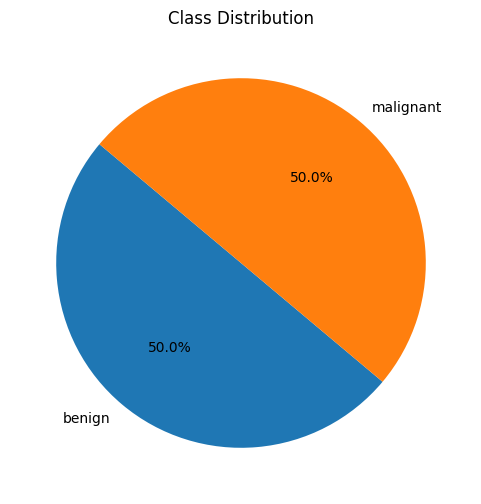

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 127MB/s] 


Epoch 1/25
----------


100%|██████████| 90/90 [00:17<00:00,  5.00it/s]


train Loss: 0.3926 Acc: 0.8118


100%|██████████| 23/23 [00:01<00:00, 12.76it/s]


val Loss: 0.3281 Acc: 0.8542

Epoch 2/25
----------


100%|██████████| 90/90 [00:17<00:00,  5.10it/s]


train Loss: 0.3414 Acc: 0.8424


100%|██████████| 23/23 [00:01<00:00, 13.45it/s]


val Loss: 0.3055 Acc: 0.8583

Epoch 3/25
----------


100%|██████████| 90/90 [00:17<00:00,  5.11it/s]


train Loss: 0.3109 Acc: 0.8576


100%|██████████| 23/23 [00:01<00:00, 13.19it/s]


val Loss: 0.3256 Acc: 0.8500

Epoch 4/25
----------


100%|██████████| 90/90 [00:17<00:00,  5.09it/s]


train Loss: 0.3103 Acc: 0.8622


100%|██████████| 23/23 [00:01<00:00, 13.36it/s]


val Loss: 0.3001 Acc: 0.8708

Epoch 5/25
----------


100%|██████████| 90/90 [00:17<00:00,  5.11it/s]


train Loss: 0.2978 Acc: 0.8681


100%|██████████| 23/23 [00:01<00:00, 13.46it/s]


val Loss: 0.2841 Acc: 0.8764

Epoch 6/25
----------


100%|██████████| 90/90 [00:17<00:00,  5.11it/s]


train Loss: 0.2776 Acc: 0.8733


100%|██████████| 23/23 [00:01<00:00, 13.26it/s]


val Loss: 0.2919 Acc: 0.8653

Epoch 7/25
----------


100%|██████████| 90/90 [00:17<00:00,  5.11it/s]


train Loss: 0.2775 Acc: 0.8750


100%|██████████| 23/23 [00:01<00:00, 13.00it/s]


val Loss: 0.3113 Acc: 0.8639

Epoch 8/25
----------


100%|██████████| 90/90 [00:17<00:00,  5.10it/s]


train Loss: 0.2298 Acc: 0.9000


100%|██████████| 23/23 [00:01<00:00, 11.72it/s]


val Loss: 0.2866 Acc: 0.8778

Epoch 9/25
----------


100%|██████████| 90/90 [00:17<00:00,  5.11it/s]


train Loss: 0.2158 Acc: 0.9007


100%|██████████| 23/23 [00:01<00:00, 13.42it/s]


val Loss: 0.2970 Acc: 0.8722

Epoch 10/25
----------


100%|██████████| 90/90 [00:17<00:00,  5.10it/s]


train Loss: 0.2089 Acc: 0.9073


100%|██████████| 23/23 [00:01<00:00, 13.25it/s]


val Loss: 0.2938 Acc: 0.8764

Epoch 11/25
----------


100%|██████████| 90/90 [00:17<00:00,  5.10it/s]


train Loss: 0.1929 Acc: 0.9139


100%|██████████| 23/23 [00:01<00:00, 13.34it/s]


val Loss: 0.3070 Acc: 0.8806

Epoch 12/25
----------


100%|██████████| 90/90 [00:17<00:00,  5.10it/s]


train Loss: 0.1971 Acc: 0.9097


100%|██████████| 23/23 [00:01<00:00, 13.41it/s]


val Loss: 0.3110 Acc: 0.8792

Epoch 13/25
----------


100%|██████████| 90/90 [00:17<00:00,  5.10it/s]


train Loss: 0.1819 Acc: 0.9247


100%|██████████| 23/23 [00:01<00:00, 13.41it/s]


val Loss: 0.3289 Acc: 0.8764

Epoch 14/25
----------


100%|██████████| 90/90 [00:17<00:00,  5.10it/s]


train Loss: 0.1850 Acc: 0.9194


100%|██████████| 23/23 [00:01<00:00, 13.32it/s]


val Loss: 0.3225 Acc: 0.8708

Epoch 15/25
----------


100%|██████████| 90/90 [00:17<00:00,  5.10it/s]


train Loss: 0.1668 Acc: 0.9313


100%|██████████| 23/23 [00:01<00:00, 13.43it/s]


val Loss: 0.3162 Acc: 0.8764

Epoch 16/25
----------


100%|██████████| 90/90 [00:17<00:00,  5.10it/s]


train Loss: 0.1668 Acc: 0.9323


100%|██████████| 23/23 [00:01<00:00, 13.18it/s]


val Loss: 0.3080 Acc: 0.8778

Epoch 17/25
----------


100%|██████████| 90/90 [00:17<00:00,  5.10it/s]


train Loss: 0.1682 Acc: 0.9319


100%|██████████| 23/23 [00:01<00:00, 13.40it/s]


val Loss: 0.3283 Acc: 0.8819

Epoch 18/25
----------


100%|██████████| 90/90 [00:17<00:00,  5.09it/s]


train Loss: 0.1705 Acc: 0.9295


100%|██████████| 23/23 [00:01<00:00, 13.36it/s]


val Loss: 0.3107 Acc: 0.8778

Epoch 19/25
----------


100%|██████████| 90/90 [00:17<00:00,  5.10it/s]


train Loss: 0.1740 Acc: 0.9243


100%|██████████| 23/23 [00:01<00:00, 13.32it/s]


val Loss: 0.3169 Acc: 0.8792

Epoch 20/25
----------


100%|██████████| 90/90 [00:17<00:00,  5.10it/s]


train Loss: 0.1675 Acc: 0.9319


100%|██████████| 23/23 [00:01<00:00, 13.22it/s]


val Loss: 0.3108 Acc: 0.8792

Epoch 21/25
----------


100%|██████████| 90/90 [00:17<00:00,  5.11it/s]


train Loss: 0.1676 Acc: 0.9295


100%|██████████| 23/23 [00:01<00:00, 13.35it/s]


val Loss: 0.3187 Acc: 0.8750

Epoch 22/25
----------


100%|██████████| 90/90 [00:17<00:00,  5.11it/s]


train Loss: 0.1666 Acc: 0.9240


100%|██████████| 23/23 [00:01<00:00, 13.40it/s]


val Loss: 0.3195 Acc: 0.8722

Epoch 23/25
----------


100%|██████████| 90/90 [00:17<00:00,  5.10it/s]


train Loss: 0.1618 Acc: 0.9285


100%|██████████| 23/23 [00:01<00:00, 13.38it/s]


val Loss: 0.3175 Acc: 0.8750

Epoch 24/25
----------


100%|██████████| 90/90 [00:17<00:00,  5.11it/s]


train Loss: 0.1591 Acc: 0.9309


100%|██████████| 23/23 [00:01<00:00, 13.18it/s]


val Loss: 0.3138 Acc: 0.8806

Epoch 25/25
----------


100%|██████████| 90/90 [00:17<00:00,  5.11it/s]


train Loss: 0.1638 Acc: 0.9344


100%|██████████| 23/23 [00:01<00:00, 13.26it/s]


val Loss: 0.3150 Acc: 0.8750

Training complete in 8m 5s
Best Val Acc: 0.8819


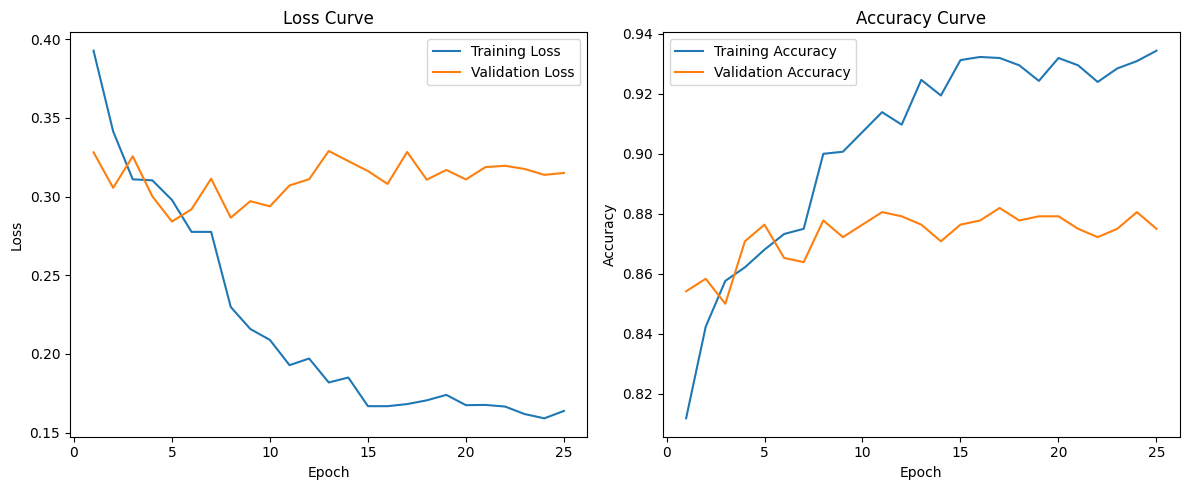

100%|██████████| 23/23 [00:01<00:00, 13.23it/s]


Classification Report:
              precision    recall  f1-score   support

      benign       0.88      0.89      0.88       360
   malignant       0.89      0.88      0.88       360

    accuracy                           0.88       720
   macro avg       0.88      0.88      0.88       720
weighted avg       0.88      0.88      0.88       720



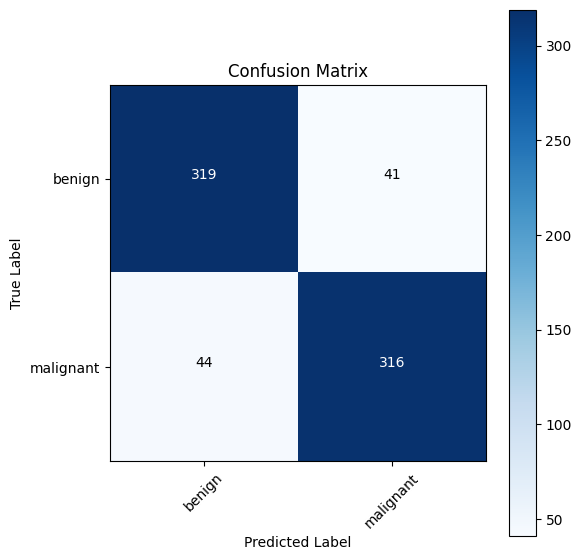

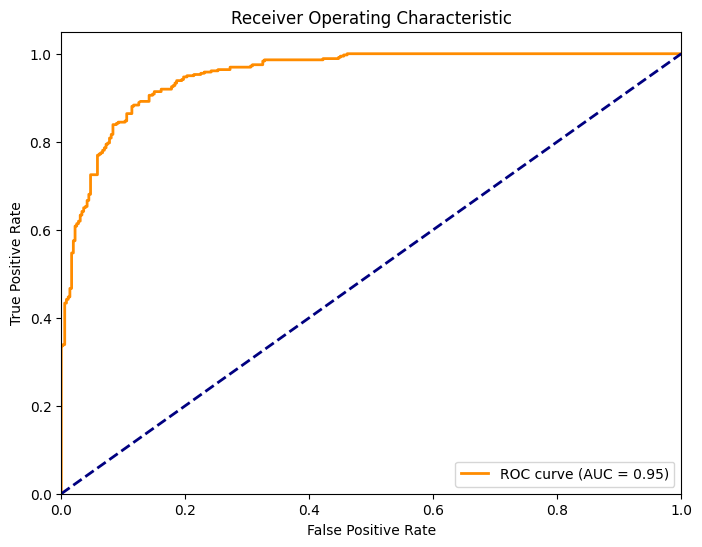

In [8]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import time
import copy
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tqdm import tqdm

# ===============================
# 1. Reproducibility & Device Setup
# ===============================
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ===============================
# 2. Data Preparation & Augmentation
# ===============================
# Adjust these paths as per your dataset structure.
data_dir = '/kaggle/input/unet-cyclegan/U-Net++segmented_output-2'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

# Data augmentation for training and simple transforms for testing.
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load datasets using ImageFolder (ensure your folder names match)
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

# -------------------------------
# Visualization 1: Pie Chart of Class Distribution
# -------------------------------
def plot_class_distribution(dataset):
    class_names = dataset.classes
    class_counts = {class_name: 0 for class_name in class_names}
    for _, label in dataset.imgs:
        class_counts[class_names[label]] += 1
    labels = list(class_counts.keys())
    counts = list(class_counts.values())
    
    plt.figure(figsize=(6,6))
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title('Class Distribution')
    plt.show()

plot_class_distribution(train_dataset)

# Create DataLoaders
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# ===============================
# 3. Model Initialization & Fine-Tuning
# ===============================
# Load pre-trained ResNet50 and modify the final layer for 2 classes.
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model_ft.parameters(), lr=1e-4)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# ===============================
# 4. Training Function
# ===============================
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Lists to store training history for visualization.
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set to training mode.
                dataloader = train_loader
            else:
                model.eval()   # Set to evaluation mode.
                dataloader = test_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())

            # Deep copy the model if performance improves.
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Val Acc: {:.4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    history = {
        'train_loss': train_loss_history,
        'train_acc': train_acc_history,
        'val_loss': val_loss_history,
        'val_acc': val_acc_history
    }
    return model, history

# Train the model (adjust the number of epochs as needed)
num_epochs = 25
model_ft, history = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=num_epochs)

# -------------------------------
# Visualization 2: Accuracy & Loss Curves
# -------------------------------
def plot_training_curves(history):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12,5))
    
    # Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Training Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_curves(history)

# ===============================
# 5. Model Evaluation on Test Set
# ===============================
model_ft.eval()
all_preds = []
all_probs = []  # Store probabilities for the positive class (malignant)
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_ft(inputs)
        probs = nn.functional.softmax(outputs, dim=1)[:, 1]  # Probability for class 1
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# -------------------------------
# Visualization 3: Classification Report
# -------------------------------
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

# -------------------------------
# Visualization 4: Confusion Matrix
# -------------------------------
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(train_dataset.classes))
plt.xticks(tick_marks, train_dataset.classes, rotation=45)
plt.yticks(tick_marks, train_dataset.classes)

thresh = cm.max() / 2.0
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# -------------------------------
# Visualization 5: ROC Curve and AUC
# -------------------------------
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# ConvNeXt_Base

Using device: cuda:0
Train Set Distribution:


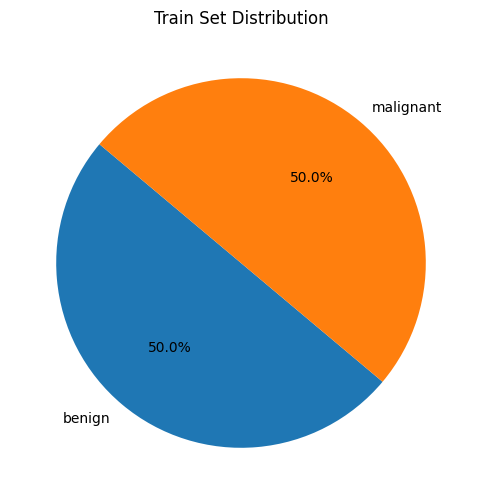

Test Set Distribution:


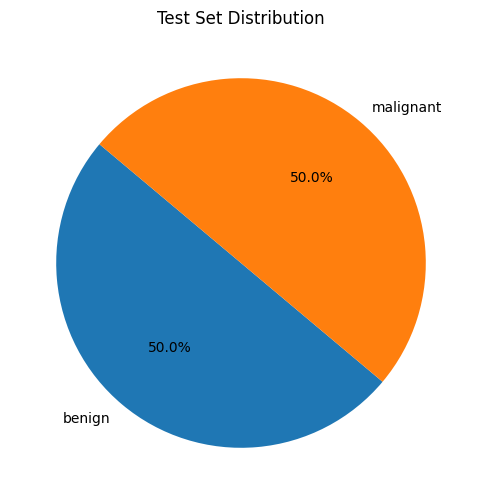

Downloading: "https://download.pytorch.org/models/convnext_base-6075fbad.pth" to /root/.cache/torch/hub/checkpoints/convnext_base-6075fbad.pth
100%|██████████| 338M/338M [00:01<00:00, 189MB/s]  
/tmp/ipykernel_31/191547070.py:121: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # For mixed precision training


Epoch 1/25
----------


train:   0%|          | 0/360 [00:00<?, ?it/s]/tmp/ipykernel_31/191547070.py:144: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
train: 100%|██████████| 360/360 [00:45<00:00,  7.88it/s]


Train Loss: 0.5022 Acc: 0.7601


val: 100%|██████████| 90/90 [00:04<00:00, 21.14it/s]


Val Loss: 0.4168 Acc: 0.8000

Epoch 2/25
----------


train: 100%|██████████| 360/360 [00:45<00:00,  7.95it/s]


Train Loss: 0.3952 Acc: 0.8208


val: 100%|██████████| 90/90 [00:03<00:00, 27.14it/s]


Val Loss: 0.3169 Acc: 0.8528

Epoch 3/25
----------


train: 100%|██████████| 360/360 [00:46<00:00,  7.77it/s]


Train Loss: 0.3638 Acc: 0.8382


val: 100%|██████████| 90/90 [00:03<00:00, 27.37it/s]


Val Loss: 0.2860 Acc: 0.8639

Epoch 4/25
----------


train: 100%|██████████| 360/360 [00:45<00:00,  7.83it/s]


Train Loss: 0.3344 Acc: 0.8372


val: 100%|██████████| 90/90 [00:03<00:00, 27.26it/s]


Val Loss: 0.3215 Acc: 0.8597

Epoch 5/25
----------


train: 100%|██████████| 360/360 [00:46<00:00,  7.74it/s]


Train Loss: 0.3240 Acc: 0.8535


val: 100%|██████████| 90/90 [00:03<00:00, 26.44it/s]


Val Loss: 0.3427 Acc: 0.8639

Epoch 6/25
----------


train: 100%|██████████| 360/360 [00:46<00:00,  7.80it/s]


Train Loss: 0.3084 Acc: 0.8587


val: 100%|██████████| 90/90 [00:03<00:00, 26.60it/s]


Val Loss: 0.3028 Acc: 0.8778

Epoch 7/25
----------


train: 100%|██████████| 360/360 [00:46<00:00,  7.82it/s]


Train Loss: 0.3033 Acc: 0.8618


val: 100%|██████████| 90/90 [00:03<00:00, 24.77it/s]


Val Loss: 0.2643 Acc: 0.9014

Epoch 8/25
----------


train: 100%|██████████| 360/360 [00:46<00:00,  7.80it/s]


Train Loss: 0.2496 Acc: 0.8958


val: 100%|██████████| 90/90 [00:03<00:00, 27.22it/s]


Val Loss: 0.2755 Acc: 0.8889

Epoch 9/25
----------


train: 100%|██████████| 360/360 [00:46<00:00,  7.80it/s]


Train Loss: 0.2291 Acc: 0.8976


val: 100%|██████████| 90/90 [00:03<00:00, 27.06it/s]


Val Loss: 0.2722 Acc: 0.8958

Epoch 10/25
----------


train: 100%|██████████| 360/360 [00:46<00:00,  7.81it/s]


Train Loss: 0.2175 Acc: 0.9083


val: 100%|██████████| 90/90 [00:03<00:00, 27.31it/s]


Val Loss: 0.2773 Acc: 0.9014

Epoch 11/25
----------


train: 100%|██████████| 360/360 [00:46<00:00,  7.82it/s]


Train Loss: 0.2114 Acc: 0.9094


val: 100%|██████████| 90/90 [00:03<00:00, 27.21it/s]


Val Loss: 0.2673 Acc: 0.8986

Epoch 12/25
----------


train: 100%|██████████| 360/360 [00:46<00:00,  7.77it/s]


Train Loss: 0.1951 Acc: 0.9201


val: 100%|██████████| 90/90 [00:03<00:00, 26.55it/s]


Val Loss: 0.2885 Acc: 0.9000

Epoch 13/25
----------


train: 100%|██████████| 360/360 [00:46<00:00,  7.81it/s]


Train Loss: 0.1930 Acc: 0.9205


val: 100%|██████████| 90/90 [00:03<00:00, 25.77it/s]


Val Loss: 0.2920 Acc: 0.8972

Epoch 14/25
----------


train: 100%|██████████| 360/360 [00:46<00:00,  7.80it/s]


Train Loss: 0.1866 Acc: 0.9181


val: 100%|██████████| 90/90 [00:03<00:00, 27.22it/s]


Val Loss: 0.2899 Acc: 0.8847

Epoch 15/25
----------


train: 100%|██████████| 360/360 [00:46<00:00,  7.81it/s]


Train Loss: 0.1720 Acc: 0.9281


val: 100%|██████████| 90/90 [00:03<00:00, 26.74it/s]


Val Loss: 0.2935 Acc: 0.8889

Epoch 16/25
----------


train: 100%|██████████| 360/360 [00:46<00:00,  7.80it/s]


Train Loss: 0.1791 Acc: 0.9205


val: 100%|██████████| 90/90 [00:03<00:00, 27.26it/s]


Val Loss: 0.2953 Acc: 0.8861

Epoch 17/25
----------


train: 100%|██████████| 360/360 [00:46<00:00,  7.81it/s]


Train Loss: 0.1773 Acc: 0.9264


val: 100%|██████████| 90/90 [00:03<00:00, 27.12it/s]


Val Loss: 0.2959 Acc: 0.8875

Epoch 18/25
----------


train: 100%|██████████| 360/360 [00:46<00:00,  7.82it/s]


Train Loss: 0.1841 Acc: 0.9160


val: 100%|██████████| 90/90 [00:03<00:00, 27.30it/s]


Val Loss: 0.2954 Acc: 0.8903

Epoch 19/25
----------


train: 100%|██████████| 360/360 [00:46<00:00,  7.77it/s]


Train Loss: 0.1713 Acc: 0.9285


val: 100%|██████████| 90/90 [00:03<00:00, 27.26it/s]


Val Loss: 0.2967 Acc: 0.8931

Epoch 20/25
----------


train: 100%|██████████| 360/360 [00:46<00:00,  7.82it/s]


Train Loss: 0.1705 Acc: 0.9316


val: 100%|██████████| 90/90 [00:03<00:00, 27.21it/s]


Val Loss: 0.2995 Acc: 0.8903

Epoch 21/25
----------


train: 100%|██████████| 360/360 [00:46<00:00,  7.81it/s]


Train Loss: 0.1655 Acc: 0.9267


val: 100%|██████████| 90/90 [00:03<00:00, 27.14it/s]


Val Loss: 0.3035 Acc: 0.8917

Epoch 22/25
----------


train: 100%|██████████| 360/360 [00:46<00:00,  7.82it/s]


Train Loss: 0.1699 Acc: 0.9229


val: 100%|██████████| 90/90 [00:03<00:00, 27.32it/s]


Val Loss: 0.3036 Acc: 0.8903

Epoch 23/25
----------


train: 100%|██████████| 360/360 [00:46<00:00,  7.80it/s]


Train Loss: 0.1669 Acc: 0.9274


val: 100%|██████████| 90/90 [00:03<00:00, 27.29it/s]


Val Loss: 0.3039 Acc: 0.8903

Epoch 24/25
----------


train: 100%|██████████| 360/360 [00:46<00:00,  7.82it/s]


Train Loss: 0.1575 Acc: 0.9337


val: 100%|██████████| 90/90 [00:03<00:00, 26.95it/s]


Val Loss: 0.3043 Acc: 0.8903

Epoch 25/25
----------


train: 100%|██████████| 360/360 [00:46<00:00,  7.81it/s]


Train Loss: 0.1714 Acc: 0.9271


val: 100%|██████████| 90/90 [00:03<00:00, 27.21it/s]


Val Loss: 0.3044 Acc: 0.8917

Training complete in 20m 37s
Best Validation Acc: 0.9014


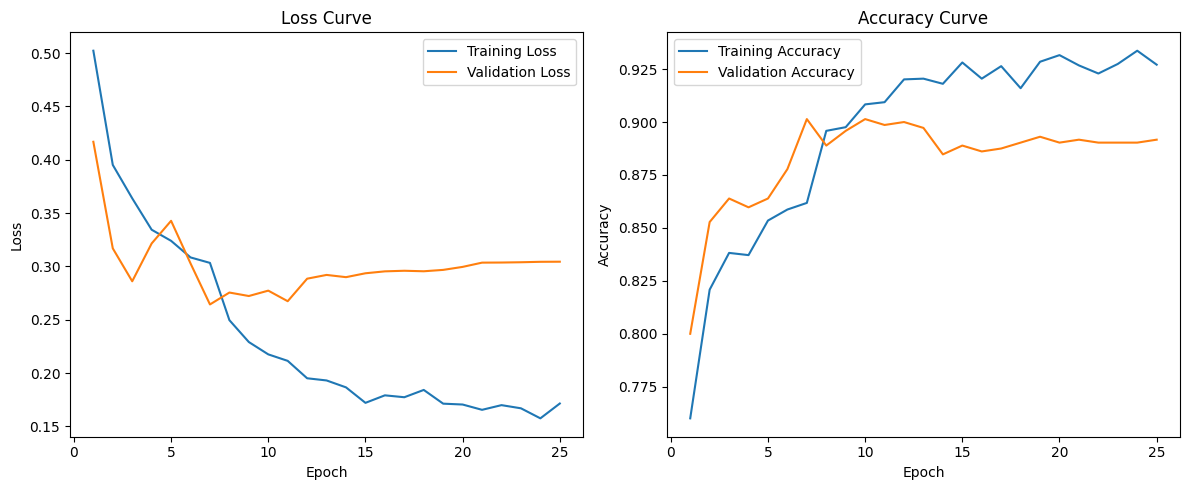

Testing: 100%|██████████| 90/90 [00:08<00:00, 10.08it/s]


Classification Report:
              precision    recall  f1-score   support

      benign       0.91      0.89      0.90       360
   malignant       0.89      0.91      0.90       360

    accuracy                           0.90       720
   macro avg       0.90      0.90      0.90       720
weighted avg       0.90      0.90      0.90       720



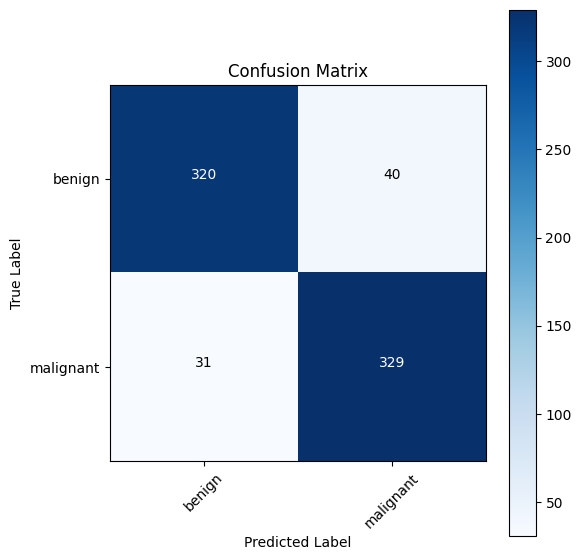

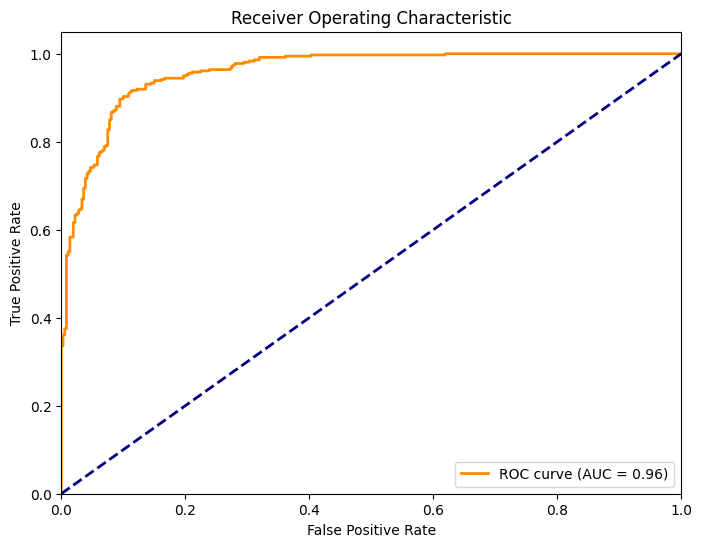

In [1]:
  # Set environment variable to help avoid fragmentation issues
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import time
import copy
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tqdm import tqdm

# Clear GPU cache before starting
torch.cuda.empty_cache()

########################################
# 1. Reproducibility & Device Setup
########################################
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

########################################
# 2. Data Preparation & Augmentation
########################################
data_dir = '/kaggle/input/unet-cyclegan/U-Net++segmented_output-2'  # Update this path as needed
train_dir = os.path.join(data_dir, 'train')
test_dir  = os.path.join(data_dir, 'test')

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset  = datasets.ImageFolder(test_dir, transform=test_transforms)

########################################
# 3. Visualization 1: Dataset Class Distribution (Pie Chart)
########################################
def plot_class_distribution(dataset, title="Class Distribution"):
    class_names = dataset.classes
    class_counts = {name: 0 for name in class_names}
    for _, label in dataset.samples:
        class_counts[class_names[label]] += 1
    labels = list(class_counts.keys())
    counts = list(class_counts.values())
    plt.figure(figsize=(6,6))
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.show()

print("Train Set Distribution:")
plot_class_distribution(train_dataset, "Train Set Distribution")
print("Test Set Distribution:")
plot_class_distribution(test_dataset, "Test Set Distribution")

########################################
# 4. DataLoaders
########################################
# To further conserve memory, we use a smaller batch size and fewer workers.
batch_size = 8  # Try reducing to 8 if 16/32 cause memory issues
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1)

########################################
# 5. Model Initialization & Fine-Tuning (ConvNeXt-Base)
########################################
from torchvision.models import convnext_base, ConvNeXt_Base_Weights
weights = ConvNeXt_Base_Weights.IMAGENET1K_V1
model_convnext = convnext_base(weights=weights)
# The original classifier is a Sequential with (LayerNorm, Flatten, Linear)
# We rebuild it to flatten first, then apply LayerNorm, dropout, and a final Linear layer.
in_features = model_convnext.classifier[2].in_features
model_convnext.classifier = nn.Sequential(
    nn.Flatten(),
    nn.LayerNorm(in_features, eps=1e-6),
    nn.Dropout(p=0.5),
    nn.Linear(in_features, 2)
)
model_convnext = model_convnext.to(device)

########################################
# 6. Training Function with Mixed Precision (AMP)
########################################
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    scaler = torch.cuda.amp.GradScaler()  # For mixed precision training

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = test_loader

            running_loss = 0.0
            running_corrects = 0
            total_samples = 0

            for inputs, labels in tqdm(dataloader, desc=phase):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    with torch.cuda.amp.autocast():
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()
                total_samples += inputs.size(0)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / total_samples
            epoch_acc = running_corrects / total_samples
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best Validation Acc: {best_acc:.4f}")

    model.load_state_dict(best_model_wts)
    history = {
        'train_loss': train_loss_history,
        'train_acc': train_acc_history,
        'val_loss': val_loss_history,
        'val_acc': val_acc_history
    }
    return model, history

########################################
# 7. Set Loss Function, Optimizer, and Scheduler
########################################
criterion = nn.CrossEntropyLoss()
optimizer_convnext = optim.Adam(model_convnext.parameters(), lr=1e-4)
scheduler_convnext = lr_scheduler.StepLR(optimizer_convnext, step_size=7, gamma=0.1)

########################################
# 8. Train the Model
########################################
num_epochs = 25
model_convnext, history = train_model(model_convnext, criterion, optimizer_convnext, scheduler_convnext, num_epochs=num_epochs)

########################################
# 9. Visualization 2: Training Curves (Accuracy & Loss)
########################################
def plot_training_curves(history):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12,5))
    
    # Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Training Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_curves(history)

########################################
# 10. Model Evaluation on Test Set
########################################
model_convnext.eval()
all_preds = []
all_probs = []  # Probabilities for malignant (class index 1)
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_convnext(inputs)
        probs = nn.functional.softmax(outputs, dim=1)[:, 1]  # Probability for class 1
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

########################################
# 11. Visualization 3: Classification Report
########################################
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

########################################
# 12. Visualization 4: Confusion Matrix
########################################
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(train_dataset.classes))
plt.xticks(tick_marks, train_dataset.classes, rotation=45)
plt.yticks(tick_marks, train_dataset.classes)
thresh = cm.max() / 2.0
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

########################################
# 13. Visualization 5: ROC Curve & AUC
########################################
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Swin Transformer‐B

Using device: cuda:0
Train Set Distribution:


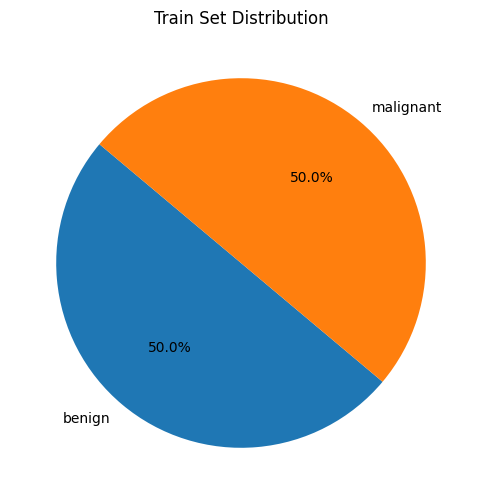

Test Set Distribution:


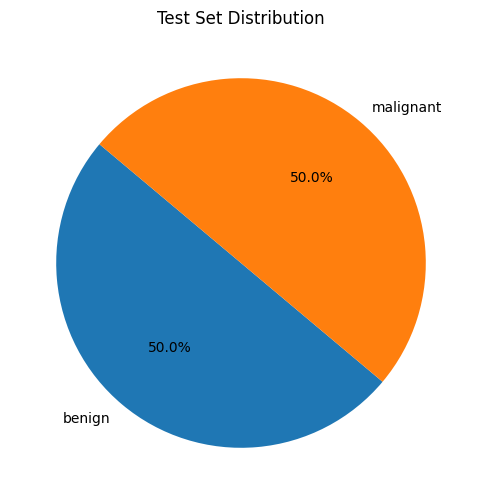

Downloading: "https://download.pytorch.org/models/swin_b-68c6b09e.pth" to /root/.cache/torch/hub/checkpoints/swin_b-68c6b09e.pth
100%|██████████| 335M/335M [00:01<00:00, 205MB/s]  
/tmp/ipykernel_31/3942170336.py:128: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Epoch 1/25
----------


train:   0%|          | 0/180 [00:00<?, ?it/s]/tmp/ipykernel_31/3942170336.py:152: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
train: 100%|██████████| 180/180 [00:48<00:00,  3.69it/s]


Train Loss: 0.4937 Acc: 0.7618


val: 100%|██████████| 45/45 [00:04<00:00, 10.89it/s]


Val Loss: 0.3275 Acc: 0.8472

Epoch 2/25
----------


train: 100%|██████████| 180/180 [00:47<00:00,  3.78it/s]


Train Loss: 0.4003 Acc: 0.8118


val: 100%|██████████| 45/45 [00:04<00:00, 10.76it/s]


Val Loss: 0.3186 Acc: 0.8486

Epoch 3/25
----------


train: 100%|██████████| 180/180 [00:47<00:00,  3.78it/s]


Train Loss: 0.3691 Acc: 0.8264


val: 100%|██████████| 45/45 [00:04<00:00, 10.77it/s]


Val Loss: 0.2986 Acc: 0.8653

Epoch 4/25
----------


train: 100%|██████████| 180/180 [00:47<00:00,  3.77it/s]


Train Loss: 0.3649 Acc: 0.8250


val: 100%|██████████| 45/45 [00:04<00:00, 10.82it/s]


Val Loss: 0.3528 Acc: 0.8500

Epoch 5/25
----------


train: 100%|██████████| 180/180 [00:47<00:00,  3.78it/s]


Train Loss: 0.3418 Acc: 0.8465


val: 100%|██████████| 45/45 [00:04<00:00, 10.87it/s]


Val Loss: 0.3056 Acc: 0.8569

Epoch 6/25
----------


train: 100%|██████████| 180/180 [00:47<00:00,  3.77it/s]


Train Loss: 0.3411 Acc: 0.8438


val: 100%|██████████| 45/45 [00:04<00:00, 10.75it/s]


Val Loss: 0.3026 Acc: 0.8556

Epoch 7/25
----------


train: 100%|██████████| 180/180 [00:47<00:00,  3.77it/s]


Train Loss: 0.3129 Acc: 0.8580


val: 100%|██████████| 45/45 [00:04<00:00, 10.83it/s]


Val Loss: 0.2779 Acc: 0.8611

Epoch 8/25
----------


train: 100%|██████████| 180/180 [00:47<00:00,  3.78it/s]


Train Loss: 0.2751 Acc: 0.8757


val: 100%|██████████| 45/45 [00:04<00:00, 10.81it/s]


Val Loss: 0.2797 Acc: 0.8778

Epoch 9/25
----------


train: 100%|██████████| 180/180 [00:47<00:00,  3.78it/s]


Train Loss: 0.2633 Acc: 0.8788


val: 100%|██████████| 45/45 [00:04<00:00, 10.81it/s]


Val Loss: 0.2769 Acc: 0.8806

Epoch 10/25
----------


train: 100%|██████████| 180/180 [00:47<00:00,  3.78it/s]


Train Loss: 0.2602 Acc: 0.8823


val: 100%|██████████| 45/45 [00:04<00:00, 10.80it/s]


Val Loss: 0.2733 Acc: 0.8736

Epoch 11/25
----------


train: 100%|██████████| 180/180 [00:47<00:00,  3.78it/s]


Train Loss: 0.2437 Acc: 0.8854


val: 100%|██████████| 45/45 [00:04<00:00, 10.61it/s]


Val Loss: 0.2839 Acc: 0.8694

Epoch 12/25
----------


train: 100%|██████████| 180/180 [00:47<00:00,  3.78it/s]


Train Loss: 0.2441 Acc: 0.8872


val: 100%|██████████| 45/45 [00:04<00:00, 10.84it/s]


Val Loss: 0.2884 Acc: 0.8736

Epoch 13/25
----------


train: 100%|██████████| 180/180 [00:47<00:00,  3.78it/s]


Train Loss: 0.2502 Acc: 0.8889


val: 100%|██████████| 45/45 [00:04<00:00, 10.83it/s]


Val Loss: 0.2660 Acc: 0.8778

Epoch 14/25
----------


train: 100%|██████████| 180/180 [00:47<00:00,  3.78it/s]


Train Loss: 0.2390 Acc: 0.8861


val: 100%|██████████| 45/45 [00:04<00:00, 10.82it/s]


Val Loss: 0.2677 Acc: 0.8764

Epoch 15/25
----------


train: 100%|██████████| 180/180 [00:47<00:00,  3.79it/s]


Train Loss: 0.2278 Acc: 0.8941


val: 100%|██████████| 45/45 [00:04<00:00, 10.87it/s]


Val Loss: 0.2686 Acc: 0.8792

Epoch 16/25
----------


train: 100%|██████████| 180/180 [00:47<00:00,  3.79it/s]


Train Loss: 0.2307 Acc: 0.8962


val: 100%|██████████| 45/45 [00:04<00:00, 10.86it/s]


Val Loss: 0.2691 Acc: 0.8792

Epoch 17/25
----------


train: 100%|██████████| 180/180 [00:47<00:00,  3.78it/s]


Train Loss: 0.2166 Acc: 0.9024


val: 100%|██████████| 45/45 [00:04<00:00, 10.85it/s]


Val Loss: 0.2714 Acc: 0.8806

Epoch 18/25
----------


train: 100%|██████████| 180/180 [00:47<00:00,  3.78it/s]


Train Loss: 0.2255 Acc: 0.8979


val: 100%|██████████| 45/45 [00:04<00:00, 10.87it/s]


Val Loss: 0.2728 Acc: 0.8847

Epoch 19/25
----------


train: 100%|██████████| 180/180 [00:47<00:00,  3.79it/s]


Train Loss: 0.2299 Acc: 0.8927


val: 100%|██████████| 45/45 [00:04<00:00, 10.87it/s]


Val Loss: 0.2721 Acc: 0.8792

Epoch 20/25
----------


train: 100%|██████████| 180/180 [00:47<00:00,  3.79it/s]


Train Loss: 0.2272 Acc: 0.9000


val: 100%|██████████| 45/45 [00:04<00:00, 10.81it/s]


Val Loss: 0.2723 Acc: 0.8778

Epoch 21/25
----------


train: 100%|██████████| 180/180 [00:47<00:00,  3.78it/s]


Train Loss: 0.2186 Acc: 0.9049


val: 100%|██████████| 45/45 [00:04<00:00, 10.82it/s]


Val Loss: 0.2737 Acc: 0.8764

Epoch 22/25
----------


train: 100%|██████████| 180/180 [00:47<00:00,  3.78it/s]


Train Loss: 0.2146 Acc: 0.9062


val: 100%|██████████| 45/45 [00:04<00:00, 10.79it/s]


Val Loss: 0.2739 Acc: 0.8764

Epoch 23/25
----------


train: 100%|██████████| 180/180 [00:47<00:00,  3.78it/s]


Train Loss: 0.2255 Acc: 0.8920


val: 100%|██████████| 45/45 [00:04<00:00, 10.83it/s]


Val Loss: 0.2739 Acc: 0.8764

Epoch 24/25
----------


train: 100%|██████████| 180/180 [00:47<00:00,  3.78it/s]


Train Loss: 0.2292 Acc: 0.9014


val: 100%|██████████| 45/45 [00:04<00:00, 10.84it/s]


Val Loss: 0.2739 Acc: 0.8764

Epoch 25/25
----------


train: 100%|██████████| 180/180 [00:47<00:00,  3.79it/s]


Train Loss: 0.2171 Acc: 0.8979


val: 100%|██████████| 45/45 [00:04<00:00, 10.81it/s]


Val Loss: 0.2741 Acc: 0.8764

Training complete in 21m 36s
Best Validation Acc: 0.8847


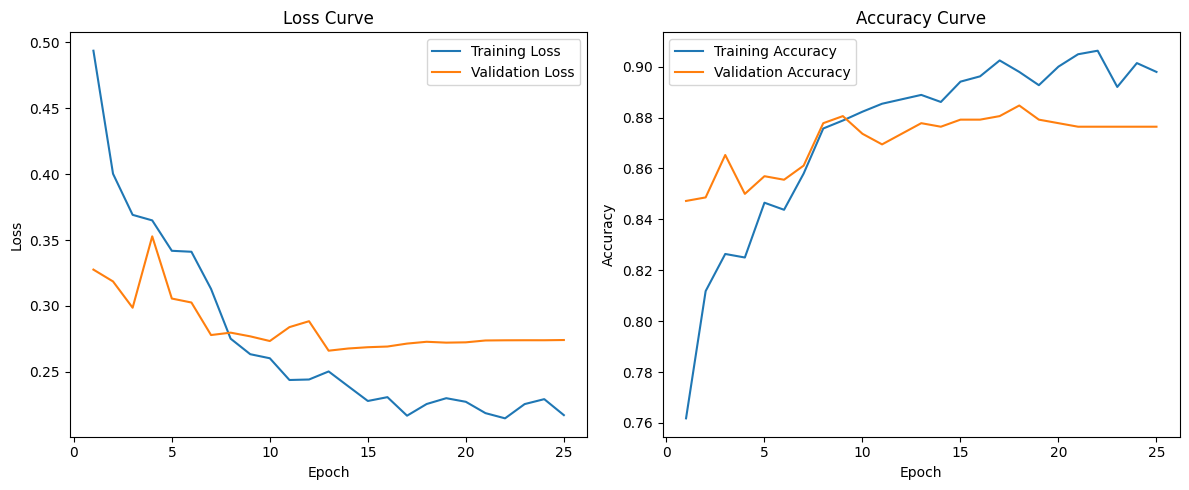

Testing: 100%|██████████| 45/45 [00:09<00:00,  4.74it/s]


Classification Report:
              precision    recall  f1-score   support

      benign       0.88      0.89      0.89       360
   malignant       0.89      0.88      0.88       360

    accuracy                           0.88       720
   macro avg       0.88      0.88      0.88       720
weighted avg       0.88      0.88      0.88       720



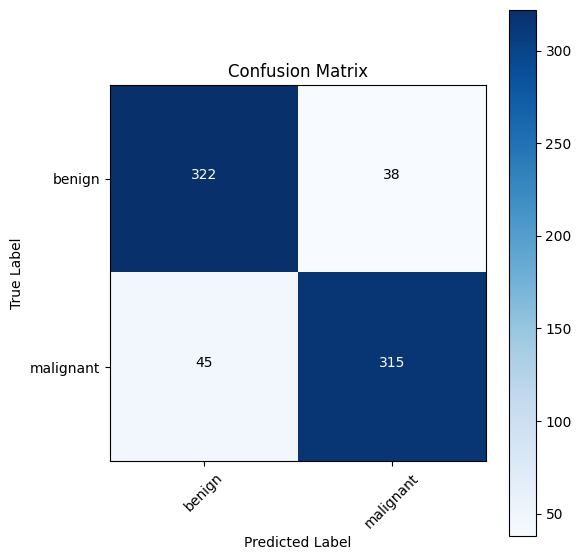

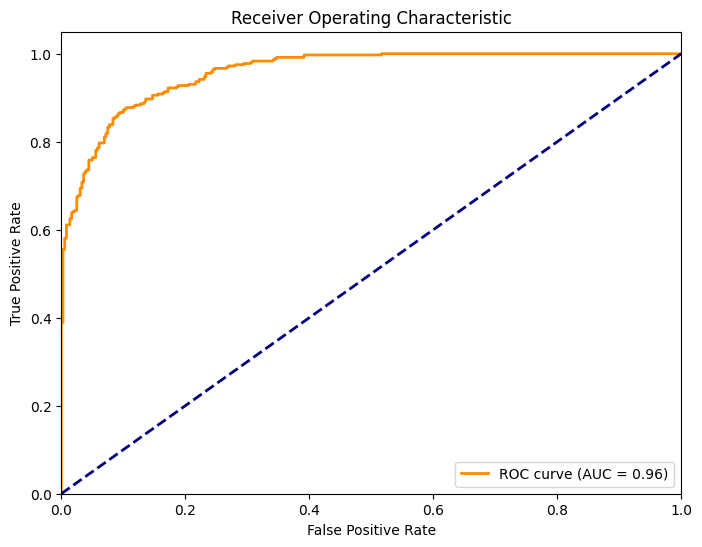

In [2]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import time
import copy
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tqdm import tqdm

########################################
# 1. Reproducibility & Device Setup
########################################
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

########################################
# 2. Data Preparation & Augmentation
########################################
# Dataset folder structure:
# data/
#   train/
#     benign/
#     malignant/
#   test/
#     benign/
#     malignant/

data_dir = '/kaggle/input/unet-cyclegan/U-Net++segmented_output-2'  # Update this path as needed
train_dir = os.path.join(data_dir, 'train')
test_dir  = os.path.join(data_dir, 'test')

# Define strong augmentations for training and standard normalization for testing.
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load datasets using ImageFolder
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset  = datasets.ImageFolder(test_dir, transform=test_transforms)

########################################
# 3. Visualization 1: Dataset Class Distribution (Pie Chart)
########################################
def plot_class_distribution(dataset, title="Class Distribution"):
    class_names = dataset.classes
    class_counts = {name: 0 for name in class_names}
    for _, label in dataset.samples:
        class_counts[class_names[label]] += 1
    labels = list(class_counts.keys())
    counts = list(class_counts.values())
    
    plt.figure(figsize=(6,6))
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.show()

print("Train Set Distribution:")
plot_class_distribution(train_dataset, "Train Set Distribution")
print("Test Set Distribution:")
plot_class_distribution(test_dataset, "Test Set Distribution")

########################################
# 4. DataLoaders
########################################
# Create DataLoaders (adjust batch_size as needed)
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

########################################
# 5. Model Initialization & Fine-Tuning (Swin Transformer-B)
########################################
# Use the pretrained Swin Transformer-B from torchvision.
from torchvision.models import swin_b, Swin_B_Weights
weights = Swin_B_Weights.IMAGENET1K_V1
model_swin = swin_b(weights=weights)

# Replace the classifier head with a dropout and a Linear layer for 2 classes.
# The Swin Transformer in torchvision uses 'model_swin.head' as its classifier.
num_features = model_swin.head.in_features
model_swin.head = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(num_features, 2)
)
model_swin = model_swin.to(device)

########################################
# 6. Training Function
########################################
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    # Use mixed precision training to reduce memory and speed up computations.
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = test_loader

            running_loss = 0.0
            running_corrects = 0
            total_samples = 0

            for inputs, labels in tqdm(dataloader, desc=phase):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    with torch.cuda.amp.autocast():
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                    if phase == 'train':
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()
                total_samples += inputs.size(0)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / total_samples
            epoch_acc = running_corrects / total_samples
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best Validation Acc: {best_acc:.4f}")

    model.load_state_dict(best_model_wts)
    history = {
        'train_loss': train_loss_history,
        'train_acc': train_acc_history,
        'val_loss': val_loss_history,
        'val_acc': val_acc_history
    }
    return model, history

########################################
# 7. Set Loss Function, Optimizer, and Scheduler
########################################
criterion = nn.CrossEntropyLoss()
optimizer_swin = optim.Adam(model_swin.parameters(), lr=1e-4)
scheduler_swin = lr_scheduler.StepLR(optimizer_swin, step_size=7, gamma=0.1)

########################################
# 8. Train the Model
########################################
num_epochs = 25
model_swin, history = train_model(model_swin, criterion, optimizer_swin, scheduler_swin, num_epochs=num_epochs)

########################################
# 9. Visualization 2: Training Curves (Accuracy & Loss)
########################################
def plot_training_curves(history):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12,5))
    
    # Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Training Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_curves(history)

########################################
# 10. Model Evaluation on Test Set
########################################
model_swin.eval()
all_preds = []
all_probs = []  # Probabilities for the malignant class (index 1)
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_swin(inputs)
        probs = nn.functional.softmax(outputs, dim=1)[:, 1]  # Class 1 probability
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

########################################
# 11. Visualization 3: Classification Report
########################################
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

########################################
# 12. Visualization 4: Confusion Matrix
########################################
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(train_dataset.classes))
plt.xticks(tick_marks, train_dataset.classes, rotation=45)
plt.yticks(tick_marks, train_dataset.classes)
thresh = cm.max() / 2.0
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

########################################
# 13. Visualization 5: ROC Curve & AUC
########################################
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# Vision Transformer ViT model (vit_base_patch16_224)

Using device: cuda:0
Train Set Distribution:


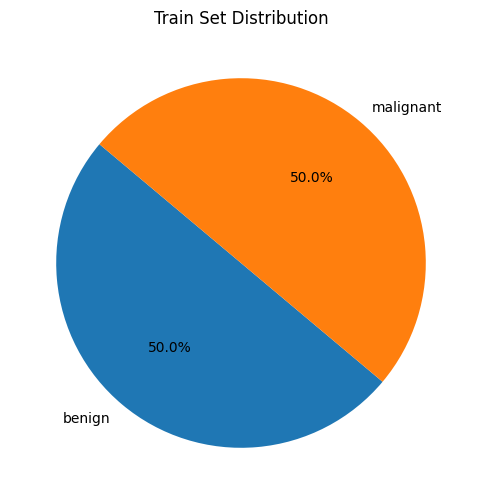

Test Set Distribution:


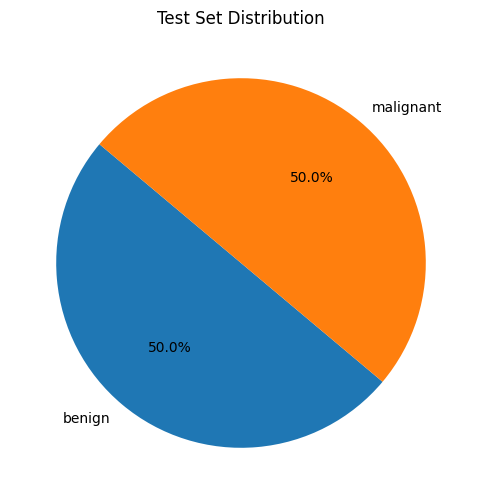

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

/tmp/ipykernel_31/1543250647.py:117: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Epoch 1/25
----------


train:   0%|          | 0/180 [00:00<?, ?it/s]/tmp/ipykernel_31/1543250647.py:141: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
train: 100%|██████████| 180/180 [00:29<00:00,  6.17it/s]


Train Loss: 0.5776 Acc: 0.7125


val: 100%|██████████| 45/45 [00:02<00:00, 18.08it/s]


Val Loss: 0.4134 Acc: 0.8042

Epoch 2/25
----------


train: 100%|██████████| 180/180 [00:28<00:00,  6.26it/s]


Train Loss: 0.4176 Acc: 0.8028


val: 100%|██████████| 45/45 [00:02<00:00, 18.78it/s]


Val Loss: 0.4309 Acc: 0.8028

Epoch 3/25
----------


train: 100%|██████████| 180/180 [00:28<00:00,  6.34it/s]


Train Loss: 0.3885 Acc: 0.8139


val: 100%|██████████| 45/45 [00:02<00:00, 19.04it/s]


Val Loss: 0.3305 Acc: 0.8431

Epoch 4/25
----------


train: 100%|██████████| 180/180 [00:28<00:00,  6.24it/s]


Train Loss: 0.3927 Acc: 0.8149


val: 100%|██████████| 45/45 [00:02<00:00, 18.79it/s]


Val Loss: 0.4201 Acc: 0.8014

Epoch 5/25
----------


train: 100%|██████████| 180/180 [00:28<00:00,  6.30it/s]


Train Loss: 0.3854 Acc: 0.8222


val: 100%|██████████| 45/45 [00:02<00:00, 19.10it/s]


Val Loss: 0.3447 Acc: 0.8458

Epoch 6/25
----------


train: 100%|██████████| 180/180 [00:28<00:00,  6.33it/s]


Train Loss: 0.3652 Acc: 0.8354


val: 100%|██████████| 45/45 [00:02<00:00, 18.91it/s]


Val Loss: 0.3781 Acc: 0.8347

Epoch 7/25
----------


train: 100%|██████████| 180/180 [00:28<00:00,  6.30it/s]


Train Loss: 0.3727 Acc: 0.8181


val: 100%|██████████| 45/45 [00:02<00:00, 18.85it/s]


Val Loss: 0.3960 Acc: 0.8125

Epoch 8/25
----------


train: 100%|██████████| 180/180 [00:28<00:00,  6.32it/s]


Train Loss: 0.3218 Acc: 0.8528


val: 100%|██████████| 45/45 [00:02<00:00, 19.04it/s]


Val Loss: 0.3236 Acc: 0.8486

Epoch 9/25
----------


train: 100%|██████████| 180/180 [00:28<00:00,  6.33it/s]


Train Loss: 0.2876 Acc: 0.8719


val: 100%|██████████| 45/45 [00:02<00:00, 18.99it/s]


Val Loss: 0.3302 Acc: 0.8556

Epoch 10/25
----------


train: 100%|██████████| 180/180 [00:28<00:00,  6.32it/s]


Train Loss: 0.2889 Acc: 0.8667


val: 100%|██████████| 45/45 [00:02<00:00, 18.86it/s]


Val Loss: 0.2921 Acc: 0.8778

Epoch 11/25
----------


train: 100%|██████████| 180/180 [00:28<00:00,  6.29it/s]


Train Loss: 0.2753 Acc: 0.8774


val: 100%|██████████| 45/45 [00:02<00:00, 18.90it/s]


Val Loss: 0.3078 Acc: 0.8569

Epoch 12/25
----------


train: 100%|██████████| 180/180 [00:28<00:00,  6.30it/s]


Train Loss: 0.2646 Acc: 0.8833


val: 100%|██████████| 45/45 [00:02<00:00, 18.83it/s]


Val Loss: 0.2932 Acc: 0.8708

Epoch 13/25
----------


train: 100%|██████████| 180/180 [00:28<00:00,  6.31it/s]


Train Loss: 0.2655 Acc: 0.8802


val: 100%|██████████| 45/45 [00:02<00:00, 19.08it/s]


Val Loss: 0.3105 Acc: 0.8639

Epoch 14/25
----------


train: 100%|██████████| 180/180 [00:28<00:00,  6.31it/s]


Train Loss: 0.2685 Acc: 0.8767


val: 100%|██████████| 45/45 [00:02<00:00, 18.89it/s]


Val Loss: 0.2987 Acc: 0.8597

Epoch 15/25
----------


train: 100%|██████████| 180/180 [00:28<00:00,  6.30it/s]


Train Loss: 0.2435 Acc: 0.8882


val: 100%|██████████| 45/45 [00:02<00:00, 18.92it/s]


Val Loss: 0.2962 Acc: 0.8694

Epoch 16/25
----------


train: 100%|██████████| 180/180 [00:28<00:00,  6.32it/s]


Train Loss: 0.2427 Acc: 0.8944


val: 100%|██████████| 45/45 [00:02<00:00, 18.99it/s]


Val Loss: 0.3023 Acc: 0.8597

Epoch 17/25
----------


train: 100%|██████████| 180/180 [00:28<00:00,  6.31it/s]


Train Loss: 0.2493 Acc: 0.8896


val: 100%|██████████| 45/45 [00:02<00:00, 18.97it/s]


Val Loss: 0.2925 Acc: 0.8681

Epoch 18/25
----------


train: 100%|██████████| 180/180 [00:28<00:00,  6.30it/s]


Train Loss: 0.2438 Acc: 0.8878


val: 100%|██████████| 45/45 [00:02<00:00, 18.92it/s]


Val Loss: 0.2930 Acc: 0.8625

Epoch 19/25
----------


train: 100%|██████████| 180/180 [00:28<00:00,  6.31it/s]


Train Loss: 0.2365 Acc: 0.8868


val: 100%|██████████| 45/45 [00:02<00:00, 18.89it/s]


Val Loss: 0.2955 Acc: 0.8653

Epoch 20/25
----------


train: 100%|██████████| 180/180 [00:28<00:00,  6.32it/s]


Train Loss: 0.2425 Acc: 0.8889


val: 100%|██████████| 45/45 [00:02<00:00, 18.88it/s]


Val Loss: 0.2947 Acc: 0.8667

Epoch 21/25
----------


train: 100%|██████████| 180/180 [00:28<00:00,  6.32it/s]


Train Loss: 0.2385 Acc: 0.8962


val: 100%|██████████| 45/45 [00:02<00:00, 18.95it/s]


Val Loss: 0.2974 Acc: 0.8569

Epoch 22/25
----------


train: 100%|██████████| 180/180 [00:28<00:00,  6.33it/s]


Train Loss: 0.2334 Acc: 0.8962


val: 100%|██████████| 45/45 [00:02<00:00, 19.11it/s]


Val Loss: 0.2987 Acc: 0.8583

Epoch 23/25
----------


train: 100%|██████████| 180/180 [00:28<00:00,  6.33it/s]


Train Loss: 0.2369 Acc: 0.8934


val: 100%|██████████| 45/45 [00:02<00:00, 18.90it/s]


Val Loss: 0.2995 Acc: 0.8583

Epoch 24/25
----------


train: 100%|██████████| 180/180 [00:28<00:00,  6.30it/s]


Train Loss: 0.2345 Acc: 0.8934


val: 100%|██████████| 45/45 [00:02<00:00, 18.92it/s]


Val Loss: 0.3010 Acc: 0.8597

Epoch 25/25
----------


train: 100%|██████████| 180/180 [00:28<00:00,  6.30it/s]


Train Loss: 0.2339 Acc: 0.8986


val: 100%|██████████| 45/45 [00:02<00:00, 18.84it/s]


Val Loss: 0.3008 Acc: 0.8597

Training complete in 12m 54s
Best Validation Acc: 0.8778


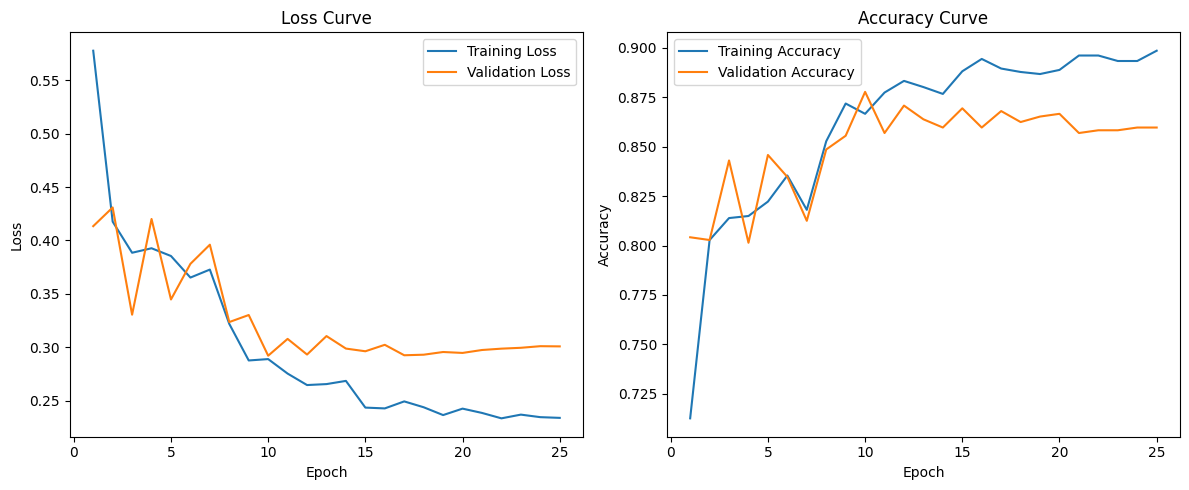

Testing: 100%|██████████| 45/45 [00:08<00:00,  5.02it/s]


Classification Report:
              precision    recall  f1-score   support

      benign       0.90      0.85      0.87       360
   malignant       0.86      0.91      0.88       360

    accuracy                           0.88       720
   macro avg       0.88      0.88      0.88       720
weighted avg       0.88      0.88      0.88       720



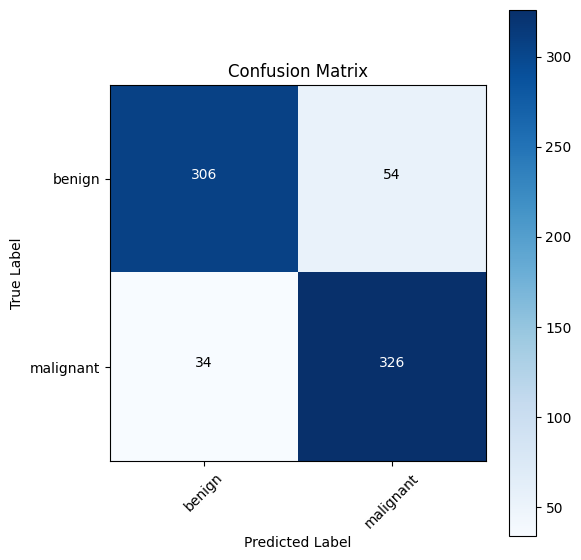

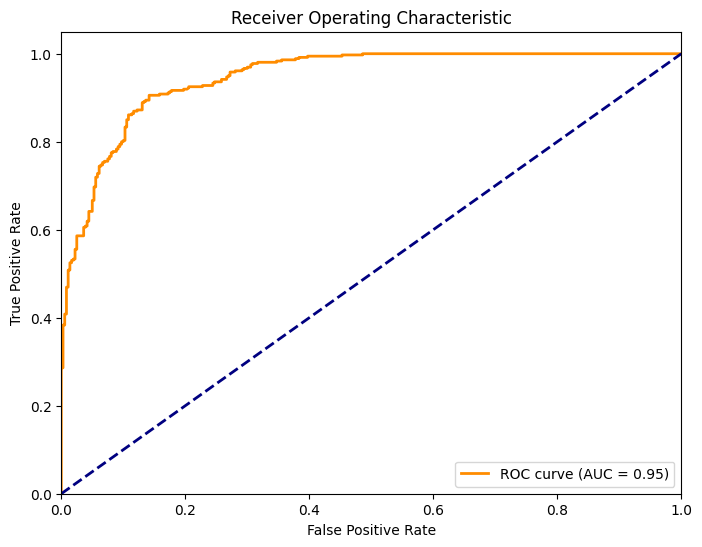

In [3]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time
import copy
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tqdm import tqdm
import timm  # for Vision Transformer

########################################
# 1. Reproducibility & Device Setup
########################################
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

########################################
# 2. Data Preparation & Augmentation
########################################
# Dataset directory structure:
# data/
#   train/
#     benign/
#     malignant/
#   test/
#     benign/
#     malignant/
data_dir = '/kaggle/input/unet-cyclegan/U-Net++segmented_output-2'  # Update path as needed
train_dir = os.path.join(data_dir, 'train')
test_dir  = os.path.join(data_dir, 'test')

# ViT typically uses 224x224 images.
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load datasets using ImageFolder
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset  = datasets.ImageFolder(test_dir, transform=test_transforms)

########################################
# 3. Visualization 1: Dataset Class Distribution (Pie Chart)
########################################
def plot_class_distribution(dataset, title="Class Distribution"):
    class_names = dataset.classes
    class_counts = {name: 0 for name in class_names}
    for _, label in dataset.samples:
        class_counts[class_names[label]] += 1
    labels = list(class_counts.keys())
    counts = list(class_counts.values())
    plt.figure(figsize=(6,6))
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.show()

print("Train Set Distribution:")
plot_class_distribution(train_dataset, "Train Set Distribution")
print("Test Set Distribution:")
plot_class_distribution(test_dataset, "Test Set Distribution")

########################################
# 4. DataLoaders
########################################
batch_size = 16  # Adjust based on GPU memory
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

########################################
# 5. Model Initialization & Fine-Tuning (Vision Transformer)
########################################
# We use TIMM to create a ViT model (vit_base_patch16_224) pretrained on ImageNet.
model_vit = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=2)
model_vit = model_vit.to(device)

########################################
# 6. Training Function
########################################
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Lists to store history
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    # Optionally, enable mixed precision training for memory and speed (if available)
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = test_loader
            
            running_loss = 0.0
            running_corrects = 0
            total_samples = 0
            
            for inputs, labels in tqdm(dataloader, desc=phase):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    with torch.cuda.amp.autocast():
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()
                total_samples += inputs.size(0)
            
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / total_samples
            epoch_acc = running_corrects / total_samples
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
            
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
        print()
    
    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best Validation Acc: {best_acc:.4f}")
    
    model.load_state_dict(best_model_wts)
    history = {
        'train_loss': train_loss_history,
        'train_acc': train_acc_history,
        'val_loss': val_loss_history,
        'val_acc': val_acc_history
    }
    return model, history

########################################
# 7. Set Loss Function, Optimizer, and Scheduler
########################################
criterion = nn.CrossEntropyLoss()
optimizer_vit = optim.Adam(model_vit.parameters(), lr=1e-4)
scheduler_vit = lr_scheduler.StepLR(optimizer_vit, step_size=7, gamma=0.1)

########################################
# 8. Train the Model
########################################
num_epochs = 25
model_vit, history = train_model(model_vit, criterion, optimizer_vit, scheduler_vit, num_epochs=num_epochs)

########################################
# 9. Visualization 2: Training Curves (Accuracy & Loss)
########################################
def plot_training_curves(history):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12,5))
    
    # Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Training Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_curves(history)

########################################
# 10. Model Evaluation on Test Set
########################################
model_vit.eval()
all_preds = []
all_probs = []  # Probabilities for malignant (class index 1)
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_vit(inputs)
        _, preds = torch.max(outputs, 1)
        probs = nn.functional.softmax(outputs, dim=1)[:, 1]  # Class 1 probability
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

########################################
# 11. Visualization 3: Classification Report
########################################
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

########################################
# 12. Visualization 4: Confusion Matrix
########################################
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(train_dataset.classes))
plt.xticks(tick_marks, train_dataset.classes, rotation=45)
plt.yticks(tick_marks, train_dataset.classes)
thresh = cm.max() / 2.0
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

########################################
# 13. Visualization 5: ROC Curve & AUC
########################################
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# A custom hybrid CNN–ViT model

Using device: cuda:0
Train Set Distribution:


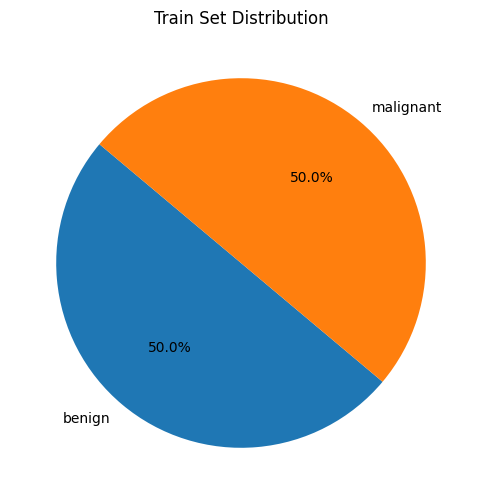

Test Set Distribution:


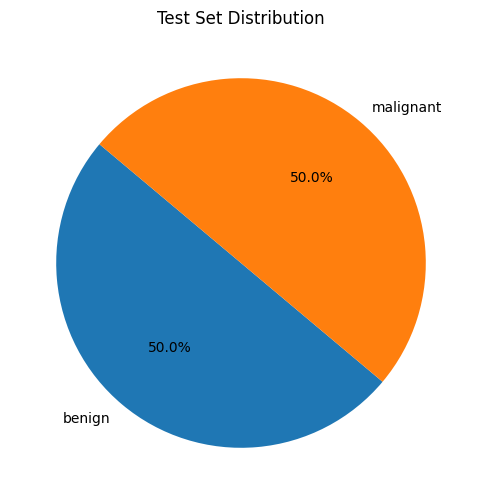

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 177MB/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batc

Epoch 1/25
----------


train:   0%|          | 0/180 [00:00<?, ?it/s]/tmp/ipykernel_31/772058421.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
train: 100%|██████████| 180/180 [00:20<00:00,  8.70it/s]


Train Loss: 0.9059 Acc: 0.6201


val: 100%|██████████| 45/45 [00:01<00:00, 25.32it/s]


Val Loss: 0.3787 Acc: 0.8389

Epoch 2/25
----------


train: 100%|██████████| 180/180 [00:19<00:00,  9.39it/s]


Train Loss: 0.5115 Acc: 0.7583


val: 100%|██████████| 45/45 [00:01<00:00, 25.80it/s]


Val Loss: 0.3659 Acc: 0.8417

Epoch 3/25
----------


train: 100%|██████████| 180/180 [00:19<00:00,  9.33it/s]


Train Loss: 0.4727 Acc: 0.7840


val: 100%|██████████| 45/45 [00:01<00:00, 25.53it/s]


Val Loss: 0.3404 Acc: 0.8528

Epoch 4/25
----------


train: 100%|██████████| 180/180 [00:19<00:00,  9.26it/s]


Train Loss: 0.4496 Acc: 0.7924


val: 100%|██████████| 45/45 [00:01<00:00, 25.03it/s]


Val Loss: 0.4740 Acc: 0.7944

Epoch 5/25
----------


train: 100%|██████████| 180/180 [00:19<00:00,  9.18it/s]


Train Loss: 0.4477 Acc: 0.8000


val: 100%|██████████| 45/45 [00:02<00:00, 22.41it/s]


Val Loss: 0.3906 Acc: 0.8250

Epoch 6/25
----------


train: 100%|██████████| 180/180 [00:19<00:00,  9.07it/s]


Train Loss: 0.4203 Acc: 0.8229


val: 100%|██████████| 45/45 [00:01<00:00, 24.61it/s]


Val Loss: 0.4227 Acc: 0.8250

Epoch 7/25
----------


train: 100%|██████████| 180/180 [00:19<00:00,  9.01it/s]


Train Loss: 0.4075 Acc: 0.8208


val: 100%|██████████| 45/45 [00:01<00:00, 24.82it/s]


Val Loss: 0.3461 Acc: 0.8153

Epoch 8/25
----------


train: 100%|██████████| 180/180 [00:19<00:00,  9.09it/s]


Train Loss: 0.3628 Acc: 0.8378


val: 100%|██████████| 45/45 [00:01<00:00, 24.86it/s]


Val Loss: 0.3173 Acc: 0.8653

Epoch 9/25
----------


train: 100%|██████████| 180/180 [00:19<00:00,  9.14it/s]


Train Loss: 0.3316 Acc: 0.8503


val: 100%|██████████| 45/45 [00:01<00:00, 24.98it/s]


Val Loss: 0.3009 Acc: 0.8625

Epoch 10/25
----------


train: 100%|██████████| 180/180 [00:19<00:00,  9.11it/s]


Train Loss: 0.3227 Acc: 0.8608


val: 100%|██████████| 45/45 [00:01<00:00, 24.67it/s]


Val Loss: 0.3049 Acc: 0.8681

Epoch 11/25
----------


train: 100%|██████████| 180/180 [00:19<00:00,  9.06it/s]


Train Loss: 0.3218 Acc: 0.8493


val: 100%|██████████| 45/45 [00:01<00:00, 24.58it/s]


Val Loss: 0.3072 Acc: 0.8722

Epoch 12/25
----------


train: 100%|██████████| 180/180 [00:19<00:00,  9.09it/s]


Train Loss: 0.3178 Acc: 0.8510


val: 100%|██████████| 45/45 [00:01<00:00, 25.02it/s]


Val Loss: 0.2952 Acc: 0.8764

Epoch 13/25
----------


train: 100%|██████████| 180/180 [00:19<00:00,  9.09it/s]


Train Loss: 0.3229 Acc: 0.8531


val: 100%|██████████| 45/45 [00:01<00:00, 24.81it/s]


Val Loss: 0.3014 Acc: 0.8708

Epoch 14/25
----------


train: 100%|██████████| 180/180 [00:19<00:00,  9.11it/s]


Train Loss: 0.3157 Acc: 0.8632


val: 100%|██████████| 45/45 [00:01<00:00, 25.05it/s]


Val Loss: 0.2955 Acc: 0.8681

Epoch 15/25
----------


train: 100%|██████████| 180/180 [00:19<00:00,  9.13it/s]


Train Loss: 0.2829 Acc: 0.8729


val: 100%|██████████| 45/45 [00:01<00:00, 24.96it/s]


Val Loss: 0.2974 Acc: 0.8694

Epoch 16/25
----------


train: 100%|██████████| 180/180 [00:19<00:00,  9.08it/s]


Train Loss: 0.2957 Acc: 0.8649


val: 100%|██████████| 45/45 [00:01<00:00, 24.78it/s]


Val Loss: 0.2949 Acc: 0.8681

Epoch 17/25
----------


train: 100%|██████████| 180/180 [00:19<00:00,  9.08it/s]


Train Loss: 0.2868 Acc: 0.8705


val: 100%|██████████| 45/45 [00:01<00:00, 24.08it/s]


Val Loss: 0.2941 Acc: 0.8736

Epoch 18/25
----------


train: 100%|██████████| 180/180 [00:19<00:00,  9.11it/s]


Train Loss: 0.2947 Acc: 0.8705


val: 100%|██████████| 45/45 [00:01<00:00, 24.79it/s]


Val Loss: 0.2891 Acc: 0.8764

Epoch 19/25
----------


train: 100%|██████████| 180/180 [00:19<00:00,  9.10it/s]


Train Loss: 0.2875 Acc: 0.8691


val: 100%|██████████| 45/45 [00:01<00:00, 24.84it/s]


Val Loss: 0.2863 Acc: 0.8764

Epoch 20/25
----------


train: 100%|██████████| 180/180 [00:19<00:00,  9.12it/s]


Train Loss: 0.2864 Acc: 0.8747


val: 100%|██████████| 45/45 [00:01<00:00, 24.82it/s]


Val Loss: 0.2950 Acc: 0.8750

Epoch 21/25
----------


train: 100%|██████████| 180/180 [00:19<00:00,  9.12it/s]


Train Loss: 0.2767 Acc: 0.8781


val: 100%|██████████| 45/45 [00:01<00:00, 24.83it/s]


Val Loss: 0.2891 Acc: 0.8722

Epoch 22/25
----------


train: 100%|██████████| 180/180 [00:19<00:00,  9.10it/s]


Train Loss: 0.2852 Acc: 0.8719


val: 100%|██████████| 45/45 [00:01<00:00, 24.96it/s]


Val Loss: 0.2847 Acc: 0.8736

Epoch 23/25
----------


train: 100%|██████████| 180/180 [00:19<00:00,  9.08it/s]


Train Loss: 0.2837 Acc: 0.8715


val: 100%|██████████| 45/45 [00:01<00:00, 24.89it/s]


Val Loss: 0.2957 Acc: 0.8722

Epoch 24/25
----------


train: 100%|██████████| 180/180 [00:19<00:00,  9.11it/s]


Train Loss: 0.2798 Acc: 0.8764


val: 100%|██████████| 45/45 [00:01<00:00, 24.60it/s]


Val Loss: 0.2925 Acc: 0.8764

Epoch 25/25
----------


train: 100%|██████████| 180/180 [00:19<00:00,  9.10it/s]


Train Loss: 0.2864 Acc: 0.8719


val: 100%|██████████| 45/45 [00:01<00:00, 24.88it/s]


Val Loss: 0.2909 Acc: 0.8778

Training complete in 8m 60s
Best Validation Acc: 0.8778


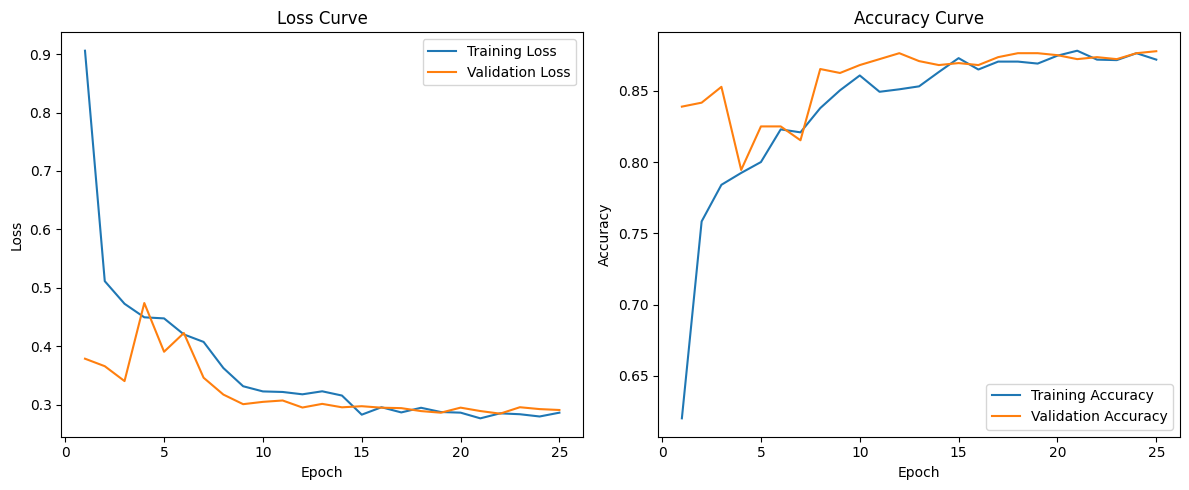

Testing: 100%|██████████| 45/45 [00:03<00:00, 12.35it/s]


Classification Report:
              precision    recall  f1-score   support

      benign       0.87      0.88      0.88       360
   malignant       0.88      0.87      0.88       360

    accuracy                           0.88       720
   macro avg       0.88      0.88      0.88       720
weighted avg       0.88      0.88      0.88       720



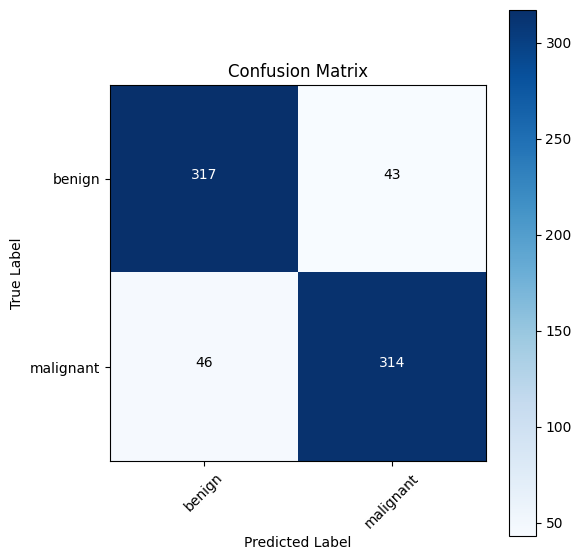

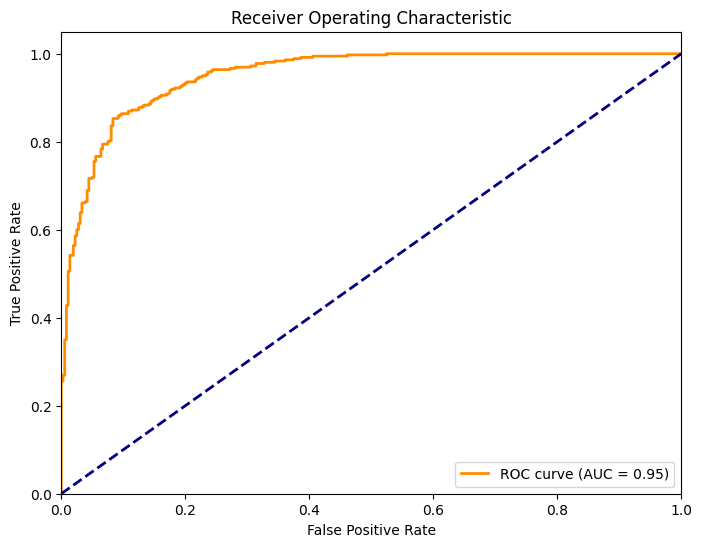

In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import time
import copy
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tqdm import tqdm

# Optionally, set environment variable to reduce fragmentation
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
torch.cuda.empty_cache()

########################################
# 1. Reproducibility & Device Setup
########################################
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

########################################
# 2. Data Preparation & Augmentation
########################################
# Dataset folder structure:
# data/
#   train/
#     benign/
#     malignant/
#   test/
#     benign/
#     malignant/
data_dir = '/kaggle/input/unet-cyclegan/U-Net++segmented_output-2'  # Adjust path as needed
train_dir = os.path.join(data_dir, 'train')
test_dir  = os.path.join(data_dir, 'test')

# We'll use strong augmentation for training.
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
# Testing transforms: resize and center crop.
test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset  = datasets.ImageFolder(test_dir, transform=test_transforms)

########################################
# 3. Visualization 1: Dataset Class Distribution (Pie Chart)
########################################
def plot_class_distribution(dataset, title="Class Distribution"):
    class_names = dataset.classes
    class_counts = {name: 0 for name in class_names}
    for _, label in dataset.samples:
        class_counts[class_names[label]] += 1
    labels = list(class_counts.keys())
    counts = list(class_counts.values())
    plt.figure(figsize=(6,6))
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.show()

print("Train Set Distribution:")
plot_class_distribution(train_dataset, "Train Set Distribution")
print("Test Set Distribution:")
plot_class_distribution(test_dataset, "Test Set Distribution")

########################################
# 4. DataLoaders
########################################
batch_size = 16  # Adjust as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

########################################
# 5. Hybrid CNN-ViT Model Definition
########################################
# This custom model uses a pretrained ResNet50 as a CNN backbone to extract spatial features.
# The feature map is flattened to a sequence of tokens, projected to a lower dimension,
# a learnable [CLS] token and positional embeddings are added,
# and the tokens are passed through a Transformer encoder.
# The [CLS] token output is then used for classification.
class HybridCNNViT(nn.Module):
    def __init__(self, num_classes=2, hidden_dim=768, num_transformer_layers=6, num_heads=8):
        super(HybridCNNViT, self).__init__()
        # Pretrained CNN Backbone (ResNet50 without avgpool and fc)
        cnn = models.resnet50(pretrained=True)
        self.cnn_backbone = nn.Sequential(*list(cnn.children())[:-2])
        # For 224x224 input, ResNet50 produces (batch, 2048, 7, 7)
        self.num_patches = 7 * 7  # 49 patches
        self.patch_dim = 2048
        # Project each patch to the hidden dimension expected by the transformer.
        self.linear_projection = nn.Linear(self.patch_dim, hidden_dim)
        # Class token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, hidden_dim))
        # Positional embedding for patches + class token
        self.pos_embedding = nn.Parameter(torch.zeros(1, self.num_patches + 1, hidden_dim))
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_transformer_layers)
        # Classification head
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(0.5)
        self._init_weights()
        
    def _init_weights(self):
        nn.init.trunc_normal_(self.pos_embedding, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)
        
    def forward(self, x):
        # x: (batch, 3, 224, 224)
        features = self.cnn_backbone(x)  # shape: (batch, 2048, 7, 7)
        batch_size = features.size(0)
        # Flatten spatial dimensions: (batch, 2048, 49) -> (batch, 49, 2048)
        features = features.flatten(2).transpose(1, 2)
        # Project to hidden dimension: (batch, 49, hidden_dim)
        tokens = self.linear_projection(features)
        # Prepare class token and concatenate: (batch, 1, hidden_dim)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        tokens = torch.cat((cls_tokens, tokens), dim=1)  # (batch, 50, hidden_dim)
        # Add positional embeddings
        tokens = tokens + self.pos_embedding
        # Permute for transformer: (sequence, batch, d_model)
        tokens = tokens.transpose(0, 1)
        # Transformer Encoder
        transformer_out = self.transformer_encoder(tokens)
        # Use the output of the class token (first token)
        cls_output = transformer_out[0]
        cls_output = self.dropout(cls_output)
        logits = self.fc(cls_output)
        return logits

# Initialize the model
model = HybridCNNViT(num_classes=2, hidden_dim=768, num_transformer_layers=6, num_heads=8)
model = model.to(device)

########################################
# 6. Training Function
########################################
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    # Mixed precision training (optional but helps with memory/speed)
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = test_loader

            running_loss = 0.0
            running_corrects = 0
            total_samples = 0

            for inputs, labels in tqdm(dataloader, desc=phase):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    with torch.cuda.amp.autocast():
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()
                total_samples += inputs.size(0)
            
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / total_samples
            epoch_acc = running_corrects / total_samples
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
        print()
    
    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best Validation Acc: {best_acc:.4f}")

    model.load_state_dict(best_model_wts)
    history = {
        'train_loss': train_loss_history,
        'train_acc': train_acc_history,
        'val_loss': val_loss_history,
        'val_acc': val_acc_history
    }
    return model, history

########################################
# 7. Set Loss Function, Optimizer, and Scheduler
########################################
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

########################################
# 8. Train the Model
########################################
num_epochs = 25
model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs)

########################################
# 9. Visualization 2: Training Curves (Accuracy & Loss)
########################################
def plot_training_curves(history):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12,5))
    
    # Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Training Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_curves(history)

########################################
# 10. Model Evaluation on Test Set
########################################
model.eval()
all_preds = []
all_probs = []  # Probabilities for malignant (class index 1)
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        probs = nn.functional.softmax(outputs, dim=1)[:, 1]  # Class 1 probability
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

########################################
# 11. Visualization 3: Classification Report
########################################
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

########################################
# 12. Visualization 4: Confusion Matrix
########################################
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(train_dataset.classes))
plt.xticks(tick_marks, train_dataset.classes, rotation=45)
plt.yticks(tick_marks, train_dataset.classes)
thresh = cm.max() / 2.0
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

########################################
# 13. Visualization 5: ROC Curve & AUC
########################################
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
